In [1]:
%matplotlib inline

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from ZilongCode.utils import get_sweep_and_awake_replay_results, get_sweep_and_awake_replay_results_using_postive_negative_peak_in_LFP

In [3]:
def get_unique_nan_index(corr_matrix):
    '''
    Get the unique column index of the nan value in the corr_matrix
    that is, the index that have nan value in the corr_matrix
    This nan value exsists because it is a W shape track with decision point 
    Input:
        corr_matrix: the correlation matrix of the ground process intensities
    Output:
        unique_nan_index: the unique column index of the nan value in the corr_matrix
    '''
    nan_index = np.argwhere(np.isnan(corr_matrix))
    #get nan_index when the first element is 0
    firstraw_nan_index = nan_index[nan_index[:, 0] == 0]
    #get the unique column index in firstraw_nan_index
    unique_nan_index = np.unique(firstraw_nan_index[:, 1])
    return unique_nan_index

In [4]:
def get_population_vector_correlation_perbin(classifier, epoch_key, DATA_DIR, smooth_sigma=3, plot=True):
    '''
    Get the correlation matrix of the ground process intensities
    Input:
        classifier: the classifier trained with the state-space model
        epoch_key: the key of the epoch
        DATA_DIR: the directory of the data
        plot: whether to plot the correlation matrix
    Output:
        correlation_decay_per_bin: the correlation decay per bin
    '''
    
    animal, day, epoch = epoch_key  
        
    #change to array and squeeze to get rid of the extra dimension
    intensity = np.array(classifier.ground_process_intensities_).squeeze()
    #get the correlation matrix of the ground process intensities
    corr_matrix = np.corrcoef(intensity.T)
    
    unique_nan_index = get_unique_nan_index(corr_matrix)
    
    rightarm_len = unique_nan_index[1]-unique_nan_index[0]
    leftarm_len = len(corr_matrix)-unique_nan_index[1]
    
    #keep columns and rows of the corr_matrix until the unique_nan_index[1]
    rightarm_corr_matrix = corr_matrix[:unique_nan_index[1], :unique_nan_index[1]]
    
    #keep columns and rows of the corr_matrix from 0 to unique_nan_index[0], 
    # and unique_nan_index[1] to len(corr_matrix)
    row_index  = np.arange(0, unique_nan_index[0])  
    row_index = np.append(row_index, np.arange(unique_nan_index[1], len(corr_matrix)))
    column_index = row_index
    leftarm_corr_matrix = corr_matrix[row_index, :][:, column_index]
    
    #get the diagonal sum of the rightarm_corr_matrix
    diagonal_sums_rightarm = []
    Offsets_rightarm = np.arange(-len(rightarm_corr_matrix) + 1, len(rightarm_corr_matrix))
    for offset in Offsets_rightarm:
        #diagonal_sum_r = np.nansum(np.diagonal(rightarm_corr_matrix, offset=offset))
        #get nanmean
        diagonal_sum_r = np.nanmean(np.diagonal(rightarm_corr_matrix, offset=offset))
        diagonal_sums_rightarm.append(diagonal_sum_r)
    
    #get the diagonal sum of the leftarm_corr_matrix    
    diagonal_sums_leftarm = []
    Offsets_leftarm = np.arange(-len(leftarm_corr_matrix) + 1, len(leftarm_corr_matrix))
    for offset in Offsets_leftarm:
        #diagonal_sum_l = np.nansum(np.diagonal(leftarm_corr_matrix, offset=offset))
        #get nanmean
        diagonal_sum_l = np.nanmean(np.diagonal(leftarm_corr_matrix, offset=offset))
        diagonal_sums_leftarm.append(diagonal_sum_l)
        
    #aveage diagonal_sums of the right arm and left arm, since they have different length
    if len(Offsets_rightarm) > len(Offsets_leftarm):
        cuts = (len(Offsets_rightarm) - len(Offsets_leftarm))/2
        diagonal_sums_rightarm = diagonal_sums_rightarm[int(cuts):int(-cuts)]
        Offsets = Offsets_leftarm
    elif len(Offsets_rightarm) < len(Offsets_leftarm):
        cuts = (len(Offsets_leftarm) - len(Offsets_rightarm))/2
        diagonal_sums_leftarm = diagonal_sums_leftarm[int(cuts):int(-cuts)]
        Offsets = Offsets_rightarm
    else:
        Offsets = Offsets_rightarm
    mean_diagonal_sums = (np.array(diagonal_sums_rightarm) + np.array(diagonal_sums_leftarm))/2 
    
    #smooth the mean_diagonal_sums
    smoothed_mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=smooth_sigma)
    try:
        #find index of all local minimas on the smoothed_mean_diagonal_sums
        local_minima_index = argrelextrema(smoothed_mean_diagonal_sums, np.less)[0]
        #keep the smallest positive index and the largest negative index
        center = int(len(smoothed_mean_diagonal_sums)/2)
        #subtract each element in local_minima_index by center
        local_minima_index = local_minima_index - center
        #find the smallest positive index
        smallest_positive_index = np.min(local_minima_index[local_minima_index>0])
        #find the largest negative index
        largest_negative_index = np.max(local_minima_index[local_minima_index<0])
        #fidn the width between the smallest positive index and the largest negative index
        width = smallest_positive_index - largest_negative_index
        #add back the center to [largest_negative_index, smallest_positive_index]
        local_minima_index = np.asarray([largest_negative_index, smallest_positive_index]) + center
        
        correlation_decay_per_bin = smoothed_mean_diagonal_sums[center] - smoothed_mean_diagonal_sums[smallest_positive_index+center] 
        correlation_decay_per_bin = correlation_decay_per_bin/(width/2)
        
    except:
        #set width as nan
        width = np.nan
        correlation_decay_per_bin = np.nan
        local_minima_index = []
    
    if plot == True:
        fig = plt.figure(figsize=(10, 3))
        #grid spec
        gs = GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[4, 1.5, 2])
        
        plt.subplot(gs[:, 0])
        #imshow of the correlation matrix
        #set raw: unique_nan_index[0]:unique_nan_index[1], column: unique_nan_index[1]:len(corr_matrix) as nan
        #set raw: unique_nan_index[1]:len(corr_matrix), column: unique_nan_index[0]:unique_nan_index[1] as nan
        corr_matrix[unique_nan_index[0]:unique_nan_index[1], unique_nan_index[1]:len(corr_matrix)] = np.nan
        corr_matrix[unique_nan_index[1]:len(corr_matrix), unique_nan_index[0]:unique_nan_index[1]] = np.nan
        plt.imshow(corr_matrix, cmap='inferno')
        plt.xlabel('Position bins')
        plt.ylabel('Position bins')
        plt.title('Population vector correlation')
        #mark the color bar 0 as cold color and 1 as hot color
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar()
        
        
        plt.subplot(gs[0, 1])
        plt.imshow(rightarm_corr_matrix, cmap='inferno')
        plt.xticks([]); plt.yticks([])
        ylabel_text = plt.ylabel('Right arm\n PVC', rotation=0, ha='center', labelpad=30)
        ylabel_text.set_y(0.3)  
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar() 
        
        plt.subplot(gs[1, 1])
        plt.imshow(leftarm_corr_matrix, cmap='inferno')
        plt.xticks([]); plt.yticks([])
        ylabel_text = plt.ylabel('Left arm\n PVC', rotation=0, ha='center', labelpad=30)
        ylabel_text.set_y(0.3)  
        plt.clim(0.5, 1)
        #add color bar
        plt.colorbar()  
        
        plt.subplot(gs[:, 2])
        plt.plot(Offsets, diagonal_sums_rightarm, 'orange', linestyle='--', alpha=0.5, linewidth=2, label='Right arm')
        plt.plot(Offsets, diagonal_sums_leftarm, 'orange', linestyle='-', alpha=0.5, linewidth=2, label='Left arm')
        plt.plot(Offsets, mean_diagonal_sums, 'k', linestyle='-', linewidth=2, label='Mean curve')
        
        #add smoothed_mean_diagonal_sums to the plot
        #plt.plot(Offsets, smoothed_mean_diagonal_sums, 'grey', linestyle='-', linewidth=2, label='Smoothed curve')
        
        #mark all local minimas on the plot as red dots
        plt.plot(Offsets[local_minima_index], mean_diagonal_sums[local_minima_index], 'ro')
        
        plt.legend()
        plt.xlabel('Diagonal offset')
        plt.ylabel('Ave. correlation')
        #add animal, day, epoch to the title
        plt.ylim(0.5, 1)
        plt.title(f"{animal}_{day:02d}_{epoch:02d}")

        plt.tight_layout()
        
        #save the figure
        fig_name = os.path.join(DATA_DIR,"PVC_figures", f"{animal}_{day:02d}_{epoch:02d}_PVC.png")
        plt.savefig(fig_name, dpi=300)
        plt.close()
    
    print(f"{animal}_{day:02d}_{epoch:02d}, unique_nan_index: {unique_nan_index}, total length: {len(corr_matrix)}, rightarm_len: {rightarm_len}, leftarm_len: {leftarm_len}, correlationperbin: {correlation_decay_per_bin}")
    
        
    return correlation_decay_per_bin, Offsets, mean_diagonal_sums, corr_matrix, unique_nan_index

In [5]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))


In [6]:
#get PVC correlatin per spatial bin for each epoch
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_corrbin_peranimal = {}; all_corrbin_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'


all_offsets = {}
all_mean_diagonal_sums = {}
all_corr_matrix = {}
all_unique_nan_index = {}
for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )

    corrbin = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key  
        
        #print load the model of epoch_key
        print(f"Loading classifier model from {animal}_{day:02d}_{epoch:02d}")

        model_name = os.path.join(
        DATA_DIR,
        "ReplayTrajectories",
        (f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_model.pkl"),
        )  
        
        #if the model exists, then load it
        if os.path.isfile(model_name):
            classifier = ClusterlessClassifier.load_model(model_name)
        else:
            print(f"Skipping {model_name}")
            continue
        
        cb, Offsets, mean_diagonal_sums, corr_matrix, unique_nan_index = get_population_vector_correlation_perbin(classifier, epoch_key, DATA_DIR, smooth_sigma=5, plot=False)
    
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_corrbin_perday.setdefault((animal, day), []).append(cb)
        
        corrbin.append(cb)
        all_offsets[(animal, day, epoch)] = Offsets
        all_mean_diagonal_sums[(animal, day, epoch)] = mean_diagonal_sums
        all_corr_matrix[(animal, day, epoch)] = corr_matrix
        all_unique_nan_index[(animal, day, epoch)] = unique_nan_index
        
    all_corrbin_peranimal[name] = corrbin

#get the mean corrbin for each animal using all_corrbin_peranimal
mean_corrbin_peranimal = {}
for key in all_corrbin_peranimal.keys():
    corrbin_peranimal = all_corrbin_peranimal[key]
    mean_corrbin = np.nanmean(corrbin_peranimal)
    mean_corrbin_peranimal[key] = mean_corrbin

#replace np.nan in all_width_perday with mean_width in mean_width_peranimal
for key in all_corrbin_perday.keys():
    corrbin_peranimal = all_corrbin_perday[key]
    #if there is np.nan value in widths_peranimal, then replace it with mean_width
    if np.nan in corrbin_peranimal:
        corrbin_peranimal = [mean_corrbin_peranimal[key[0]] if np.isnan(x) else x for x in corrbin_peranimal]
    
    all_corrbin_perday[key] = corrbin_peranimal


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading classifier model from bon_03_02


epochs:   8%|▊         | 2/24 [00:00<00:04,  4.63it/s]

bon_03_02, unique_nan_index: [25 61], total length: 101, rightarm_len: 36, leftarm_len: 40, correlationperbin: 0.00456270043654583
Loading classifier model from bon_03_04
bon_03_04, unique_nan_index: [23 56], total length: 92, rightarm_len: 33, leftarm_len: 36, correlationperbin: 0.006066487826924407
Loading classifier model from bon_03_06


epochs:  12%|█▎        | 3/24 [00:00<00:04,  4.60it/s]

bon_03_06, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.00577071588397042
Loading classifier model from bon_04_02


epochs:  17%|█▋        | 4/24 [00:00<00:04,  4.56it/s]

bon_04_02, unique_nan_index: [23 59], total length: 95, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.006680577337060032
Loading classifier model from bon_04_04


epochs:  21%|██        | 5/24 [00:01<00:04,  4.47it/s]

bon_04_04, unique_nan_index: [24 59], total length: 96, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.005513742626198987
Loading classifier model from bon_04_06


epochs:  25%|██▌       | 6/24 [00:01<00:04,  4.38it/s]

bon_04_06, unique_nan_index: [25 62], total length: 101, rightarm_len: 37, leftarm_len: 39, correlationperbin: 0.004942766004679841
Loading classifier model from bon_05_02


epochs:  33%|███▎      | 8/24 [00:01<00:03,  4.76it/s]

bon_05_02, unique_nan_index: [25 60], total length: 98, rightarm_len: 35, leftarm_len: 38, correlationperbin: 0.006007121279828698
Loading classifier model from bon_05_04
bon_05_04, unique_nan_index: [24 58], total length: 94, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.005242294389445508
Loading classifier model from bon_05_06


epochs:  38%|███▊      | 9/24 [00:01<00:03,  4.61it/s]

bon_05_06, unique_nan_index: [24 60], total length: 98, rightarm_len: 36, leftarm_len: 38, correlationperbin: 0.004055305732415211
Loading classifier model from bon_06_02


epochs:  42%|████▏     | 10/24 [00:02<00:03,  4.66it/s]

bon_06_02, unique_nan_index: [26 62], total length: 99, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.005705431676412447
Loading classifier model from bon_06_04


epochs:  46%|████▌     | 11/24 [00:02<00:02,  4.71it/s]

bon_06_04, unique_nan_index: [25 59], total length: 96, rightarm_len: 34, leftarm_len: 37, correlationperbin: 0.005168831194176462
Loading classifier model from bon_06_06


epochs:  54%|█████▍    | 13/24 [00:02<00:02,  4.82it/s]

bon_06_06, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.0045825720988873836
Loading classifier model from bon_07_02
bon_07_02, unique_nan_index: [24 59], total length: 95, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.004724446875984342
Loading classifier model from bon_07_04


epochs:  58%|█████▊    | 14/24 [00:02<00:02,  4.90it/s]

bon_07_04, unique_nan_index: [25 60], total length: 95, rightarm_len: 35, leftarm_len: 35, correlationperbin: 0.005409070807367851
Loading classifier model from bon_07_06


epochs:  62%|██████▎   | 15/24 [00:03<00:01,  4.79it/s]

bon_07_06, unique_nan_index: [25 61], total length: 98, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.006269603785245055
Loading classifier model from bon_08_02


epochs:  67%|██████▋   | 16/24 [00:03<00:01,  4.61it/s]

bon_08_02, unique_nan_index: [26 60], total length: 98, rightarm_len: 34, leftarm_len: 38, correlationperbin: 0.005793066892378782
Loading classifier model from bon_08_04


epochs:  71%|███████   | 17/24 [00:03<00:01,  4.70it/s]

bon_08_04, unique_nan_index: [25 60], total length: 98, rightarm_len: 35, leftarm_len: 38, correlationperbin: 0.00646744773181882
Loading classifier model from bon_08_06


epochs:  75%|███████▌  | 18/24 [00:03<00:01,  4.73it/s]

bon_08_06, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.007086018860123608
Loading classifier model from bon_09_02


epochs:  83%|████████▎ | 20/24 [00:04<00:00,  4.67it/s]

bon_09_02, unique_nan_index: [26 62], total length: 99, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.004212792029813284
Loading classifier model from bon_09_04
bon_09_04, unique_nan_index: [25 60], total length: 95, rightarm_len: 35, leftarm_len: 35, correlationperbin: 0.004914987510124596
Loading classifier model from bon_09_06


epochs:  88%|████████▊ | 21/24 [00:04<00:00,  4.76it/s]

bon_09_06, unique_nan_index: [24 60], total length: 96, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.0053109866313109586
Loading classifier model from bon_10_02


epochs:  96%|█████████▌| 23/24 [00:04<00:00,  4.89it/s]

bon_10_02, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.003431144461817396
Loading classifier model from bon_10_04
bon_10_04, unique_nan_index: [24 59], total length: 95, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.003913401470146688
Loading classifier model from bon_10_06


epochs: 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


bon_10_06, unique_nan_index: [24 59], total length: 96, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.009141987444992094


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Loading classifier model from fra_04_02


epochs:   4%|▎         | 1/27 [00:00<00:06,  3.78it/s]

fra_04_02, unique_nan_index: [25 62], total length: 102, rightarm_len: 37, leftarm_len: 40, correlationperbin: 0.006336466824275558
Loading classifier model from fra_04_04


epochs:   7%|▋         | 2/27 [00:00<00:05,  4.18it/s]

fra_04_04, unique_nan_index: [25 61], total length: 100, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.0066566491258816625
Loading classifier model from fra_04_06


epochs:  11%|█         | 3/27 [00:00<00:05,  4.21it/s]

fra_04_06, unique_nan_index: [27 66], total length: 107, rightarm_len: 39, leftarm_len: 41, correlationperbin: 0.007012121238184818
Loading classifier model from fra_05_02


epochs:  15%|█▍        | 4/27 [00:00<00:05,  4.17it/s]

fra_05_02, unique_nan_index: [26 63], total length: 103, rightarm_len: 37, leftarm_len: 40, correlationperbin: 0.006400230054772552
Loading classifier model from fra_05_04


epochs:  19%|█▊        | 5/27 [00:01<00:05,  4.29it/s]

fra_05_04, unique_nan_index: [26 62], total length: 101, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.005111109358878485
Loading classifier model from fra_05_06


epochs:  22%|██▏       | 6/27 [00:01<00:05,  4.04it/s]

fra_05_06, unique_nan_index: [26 64], total length: 104, rightarm_len: 38, leftarm_len: 40, correlationperbin: 0.010414510543446671
Loading classifier model from fra_06_02


epochs:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]

fra_06_02, unique_nan_index: [26 63], total length: 102, rightarm_len: 37, leftarm_len: 39, correlationperbin: 0.005633879383120411
Loading classifier model from fra_06_04


epochs:  30%|██▉       | 8/27 [00:01<00:04,  4.35it/s]

fra_06_04, unique_nan_index: [25 61], total length: 100, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.004303783584365365
Loading classifier model from fra_06_06


epochs:  33%|███▎      | 9/27 [00:02<00:04,  4.23it/s]

fra_06_06, unique_nan_index: [26 64], total length: 104, rightarm_len: 38, leftarm_len: 40, correlationperbin: 0.005922896975659227
Loading classifier model from fra_07_02


epochs:  37%|███▋      | 10/27 [00:02<00:03,  4.25it/s]

fra_07_02, unique_nan_index: [26 62], total length: 102, rightarm_len: 36, leftarm_len: 40, correlationperbin: 0.005201093933031539
Loading classifier model from fra_07_04


epochs:  41%|████      | 11/27 [00:02<00:03,  4.37it/s]

fra_07_04, unique_nan_index: [26 61], total length: 101, rightarm_len: 35, leftarm_len: 40, correlationperbin: 0.004242444150703715
Loading classifier model from fra_07_06


epochs:  44%|████▍     | 12/27 [00:02<00:03,  4.21it/s]

fra_07_06, unique_nan_index: [26 63], total length: 104, rightarm_len: 37, leftarm_len: 41, correlationperbin: 0.0038512643755111127
Loading classifier model from fra_08_02


epochs:  48%|████▊     | 13/27 [00:03<00:03,  4.33it/s]

fra_08_02, unique_nan_index: [26 62], total length: 102, rightarm_len: 36, leftarm_len: 40, correlationperbin: 0.004126023499415716
Loading classifier model from fra_08_04


epochs:  52%|█████▏    | 14/27 [00:03<00:03,  4.24it/s]

fra_08_04, unique_nan_index: [26 61], total length: 101, rightarm_len: 35, leftarm_len: 40, correlationperbin: 0.004604066165522104
Loading classifier model from fra_08_06


epochs:  56%|█████▌    | 15/27 [00:03<00:02,  4.06it/s]

fra_08_06, unique_nan_index: [26 62], total length: 102, rightarm_len: 36, leftarm_len: 40, correlationperbin: 0.0038099435611466553
Loading classifier model from fra_09_02


epochs:  59%|█████▉    | 16/27 [00:03<00:02,  3.96it/s]

fra_09_02, unique_nan_index: [25 62], total length: 101, rightarm_len: 37, leftarm_len: 39, correlationperbin: 0.0036255008333981155
Loading classifier model from fra_09_04


epochs:  63%|██████▎   | 17/27 [00:04<00:02,  4.02it/s]

fra_09_04, unique_nan_index: [25 60], total length: 98, rightarm_len: 35, leftarm_len: 38, correlationperbin: 0.003139937767792915
Loading classifier model from fra_09_06


epochs:  67%|██████▋   | 18/27 [00:04<00:02,  4.12it/s]

fra_09_06, unique_nan_index: [26 63], total length: 101, rightarm_len: 37, leftarm_len: 38, correlationperbin: 0.0030386987167064783
Loading classifier model from fra_10_02


epochs:  70%|███████   | 19/27 [00:04<00:01,  4.22it/s]

fra_10_02, unique_nan_index: [26 62], total length: 101, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.003700895574654369
Loading classifier model from fra_10_04


epochs:  74%|███████▍  | 20/27 [00:04<00:01,  4.36it/s]

fra_10_04, unique_nan_index: [25 59], total length: 98, rightarm_len: 34, leftarm_len: 39, correlationperbin: 0.0033024410922184986
Loading classifier model from fra_10_06


epochs:  78%|███████▊  | 21/27 [00:04<00:01,  4.48it/s]

fra_10_06, unique_nan_index: [26 63], total length: 100, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.0033717510383635234
Loading classifier model from fra_11_02


epochs:  81%|████████▏ | 22/27 [00:05<00:01,  4.50it/s]

fra_11_02, unique_nan_index: [26 62], total length: 100, rightarm_len: 36, leftarm_len: 38, correlationperbin: 0.004302836304563063
Loading classifier model from fra_11_04


epochs:  85%|████████▌ | 23/27 [00:05<00:00,  4.42it/s]

fra_11_04, unique_nan_index: [26 62], total length: 101, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.0038199793292973947
Loading classifier model from fra_11_06


epochs:  89%|████████▉ | 24/27 [00:05<00:00,  4.11it/s]

fra_11_06, unique_nan_index: [27 64], total length: 104, rightarm_len: 37, leftarm_len: 40, correlationperbin: 0.0036893860590579567
Loading classifier model from fra_12_02


epochs:  93%|█████████▎| 25/27 [00:05<00:00,  4.02it/s]

fra_12_02, unique_nan_index: [25 61], total length: 100, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.0039528216925420355
Loading classifier model from fra_12_04


epochs:  96%|█████████▋| 26/27 [00:06<00:00,  4.12it/s]

fra_12_04, unique_nan_index: [26 62], total length: 101, rightarm_len: 36, leftarm_len: 39, correlationperbin: 0.005610196477030864
Loading classifier model from fra_12_06


epochs: 100%|██████████| 27/27 [00:06<00:00,  4.23it/s]


fra_12_06, unique_nan_index: [26 63], total length: 101, rightarm_len: 37, leftarm_len: 38, correlationperbin: 0.004841749694841421


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading classifier model from gov_06_02


epochs:   4%|▍         | 1/24 [00:00<00:05,  4.09it/s]

gov_06_02, unique_nan_index: [27 70], total length: 109, rightarm_len: 43, leftarm_len: 39, correlationperbin: 0.0008067692360512287
Loading classifier model from gov_06_04


epochs:   8%|▊         | 2/24 [00:00<00:05,  3.68it/s]

gov_06_04, unique_nan_index: [26 68], total length: 107, rightarm_len: 42, leftarm_len: 39, correlationperbin: 0.0011857298935159138
Loading classifier model from gov_06_06


epochs:  12%|█▎        | 3/24 [00:00<00:06,  3.39it/s]

gov_06_06, unique_nan_index: [26 68], total length: 107, rightarm_len: 42, leftarm_len: 39, correlationperbin: 0.0012353061867302082
Loading classifier model from gov_07_02


epochs:  17%|█▋        | 4/24 [00:01<00:05,  3.60it/s]

gov_07_02, unique_nan_index: [26 67], total length: 106, rightarm_len: 41, leftarm_len: 39, correlationperbin: 0.0012661604567212057
Loading classifier model from gov_07_04


epochs:  21%|██        | 5/24 [00:01<00:05,  3.75it/s]

gov_07_04, unique_nan_index: [26 66], total length: 105, rightarm_len: 40, leftarm_len: 39, correlationperbin: 0.0013520954721204985
Loading classifier model from gov_07_06


epochs:  25%|██▌       | 6/24 [00:01<00:04,  3.88it/s]

gov_07_06, unique_nan_index: [27 69], total length: 109, rightarm_len: 42, leftarm_len: 40, correlationperbin: 0.000842093105975104
Loading classifier model from gov_08_02


epochs:  29%|██▉       | 7/24 [00:01<00:04,  3.81it/s]

gov_08_02, unique_nan_index: [25 65], total length: 101, rightarm_len: 40, leftarm_len: 36, correlationperbin: 0.002654430370622189
Loading classifier model from gov_08_04


epochs:  33%|███▎      | 8/24 [00:02<00:03,  4.05it/s]

gov_08_04, unique_nan_index: [25 64], total length: 101, rightarm_len: 39, leftarm_len: 37, correlationperbin: 0.0027287964258629603
Loading classifier model from gov_08_06


epochs:  38%|███▊      | 9/24 [00:02<00:03,  4.24it/s]

gov_08_06, unique_nan_index: [25 65], total length: 101, rightarm_len: 40, leftarm_len: 36, correlationperbin: nan
Loading classifier model from gov_09_02


epochs:  42%|████▏     | 10/24 [00:02<00:03,  4.33it/s]

gov_09_02, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.002188104569635266
Loading classifier model from gov_09_03


epochs:  46%|████▌     | 11/24 [00:02<00:02,  4.40it/s]

gov_09_03, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.003434564354345311
Loading classifier model from gov_09_05


epochs:  50%|█████     | 12/24 [00:02<00:02,  4.53it/s]

gov_09_05, unique_nan_index: [25 64], total length: 102, rightarm_len: 39, leftarm_len: 38, correlationperbin: 0.0020736066045143045
Loading classifier model from gov_10_02


epochs:  54%|█████▍    | 13/24 [00:03<00:02,  4.57it/s]

gov_10_02, unique_nan_index: [25 64], total length: 100, rightarm_len: 39, leftarm_len: 36, correlationperbin: 0.0008270799951804361
Loading classifier model from gov_10_04


epochs:  58%|█████▊    | 14/24 [00:03<00:02,  4.53it/s]

gov_10_04, unique_nan_index: [25 63], total length: 99, rightarm_len: 38, leftarm_len: 36, correlationperbin: 0.0006976051417854454
Loading classifier model from gov_10_06


epochs:  62%|██████▎   | 15/24 [00:03<00:02,  4.39it/s]

gov_10_06, unique_nan_index: [25 64], total length: 103, rightarm_len: 39, leftarm_len: 39, correlationperbin: 0.0014123997666920065
Loading classifier model from gov_11_02


epochs:  71%|███████   | 17/24 [00:04<00:01,  4.73it/s]

gov_11_02, unique_nan_index: [24 62], total length: 98, rightarm_len: 38, leftarm_len: 36, correlationperbin: 0.0014067577176595724
Loading classifier model from gov_11_04
gov_11_04, unique_nan_index: [24 62], total length: 97, rightarm_len: 38, leftarm_len: 35, correlationperbin: 0.0005464220364256153
Loading classifier model from gov_11_06


epochs:  75%|███████▌  | 18/24 [00:04<00:01,  4.71it/s]

gov_11_06, unique_nan_index: [25 66], total length: 104, rightarm_len: 41, leftarm_len: 38, correlationperbin: nan
Loading classifier model from gov_12_02


epochs:  79%|███████▉  | 19/24 [00:04<00:01,  4.63it/s]

gov_12_02, unique_nan_index: [25 63], total length: 103, rightarm_len: 38, leftarm_len: 40, correlationperbin: 0.001285196556519961
Loading classifier model from gov_12_04


epochs:  83%|████████▎ | 20/24 [00:04<00:00,  4.61it/s]

gov_12_04, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.0005594976843430734
Loading classifier model from gov_12_06


epochs:  88%|████████▊ | 21/24 [00:04<00:00,  4.66it/s]

gov_12_06, unique_nan_index: [25 65], total length: 103, rightarm_len: 40, leftarm_len: 38, correlationperbin: 0.0016707755382025758
Loading classifier model from gov_13_02


epochs:  92%|█████████▏| 22/24 [00:05<00:00,  4.73it/s]

gov_13_02, unique_nan_index: [25 64], total length: 100, rightarm_len: 39, leftarm_len: 36, correlationperbin: 0.0015585117832474927
Loading classifier model from gov_13_04


epochs:  96%|█████████▌| 23/24 [00:05<00:00,  4.74it/s]

gov_13_04, unique_nan_index: [25 64], total length: 100, rightarm_len: 39, leftarm_len: 36, correlationperbin: 0.0011659382763143551
Loading classifier model from gov_13_06


epochs: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


gov_13_06, unique_nan_index: [27 67], total length: 106, rightarm_len: 40, leftarm_len: 39, correlationperbin: nan


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Loading classifier model from dud_02_02


epochs: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


dud_02_02, unique_nan_index: [25 61], total length: 94, rightarm_len: 36, leftarm_len: 33, correlationperbin: 0.010334335474644666
Loading classifier model from dud_05_02
dud_05_02, unique_nan_index: [26 61], total length: 93, rightarm_len: 35, leftarm_len: 32, correlationperbin: 0.007043436190751076


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Loading classifier model from con_01_02


epochs:  13%|█▎        | 2/15 [00:00<00:02,  5.24it/s]

con_01_02, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.002847769345478745
Loading classifier model from con_01_04
con_01_04, unique_nan_index: [24 59], total length: 95, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.00258961972359149
Loading classifier model from con_02_02


epochs:  27%|██▋       | 4/15 [00:00<00:02,  5.42it/s]

con_02_02, unique_nan_index: [23 59], total length: 95, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.011699434016353724
Loading classifier model from con_02_04
con_02_04, unique_nan_index: [23 60], total length: 96, rightarm_len: 37, leftarm_len: 36, correlationperbin: 0.009602843874906546
Loading classifier model from con_03_02


epochs:  40%|████      | 6/15 [00:01<00:01,  5.32it/s]

con_03_02, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.005724418524387098
Loading classifier model from con_03_04
con_03_04, unique_nan_index: [24 60], total length: 97, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.00618984215224444
Loading classifier model from con_04_02


epochs:  53%|█████▎    | 8/15 [00:01<00:01,  5.16it/s]

con_04_02, unique_nan_index: [23 62], total length: 100, rightarm_len: 39, leftarm_len: 38, correlationperbin: 0.006312011962360347
Loading classifier model from con_04_04
con_04_04, unique_nan_index: [24 63], total length: 100, rightarm_len: 39, leftarm_len: 37, correlationperbin: 0.00990058905636147
Loading classifier model from con_04_06


epochs:  67%|██████▋   | 10/15 [00:01<00:00,  5.32it/s]

con_04_06, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.006943112496656481
Loading classifier model from con_05_02
con_05_02, unique_nan_index: [24 60], total length: 96, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.00907506951046088
Loading classifier model from con_05_04


epochs:  80%|████████  | 12/15 [00:02<00:00,  5.44it/s]

con_05_04, unique_nan_index: [23 60], total length: 95, rightarm_len: 37, leftarm_len: 35, correlationperbin: 0.011619376345172856
Loading classifier model from con_05_06
con_05_06, unique_nan_index: [23 59], total length: 96, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.008687173903541819
Loading classifier model from con_06_02


epochs:  93%|█████████▎| 14/15 [00:02<00:00,  5.59it/s]

con_06_02, unique_nan_index: [22 59], total length: 95, rightarm_len: 37, leftarm_len: 36, correlationperbin: 0.01418855198784602
Loading classifier model from con_06_04
con_06_04, unique_nan_index: [22 58], total length: 94, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.012231216249596258
Loading classifier model from con_06_06


epochs: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


con_06_06, unique_nan_index: [23 60], total length: 97, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.01372266818873408


epochs:   7%|▋         | 1/15 [00:00<00:02,  5.08it/s]

Loading classifier model from dav_03_02
dav_03_02, unique_nan_index: [25 60], total length: 98, rightarm_len: 35, leftarm_len: 38, correlationperbin: 0.001656232534182117
Loading classifier model from dav_03_04


epochs:  20%|██        | 3/15 [00:00<00:02,  5.16it/s]

dav_03_04, unique_nan_index: [24 59], total length: 96, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.0017562904102293468
Loading classifier model from dav_03_06
dav_03_06, unique_nan_index: [25 59], total length: 96, rightarm_len: 34, leftarm_len: 37, correlationperbin: 0.0022959400286704634
Loading classifier model from dav_04_02


epochs:  33%|███▎      | 5/15 [00:00<00:01,  5.56it/s]

dav_04_02, unique_nan_index: [24 58], total length: 94, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.0019468358062971049
Loading classifier model from dav_04_04
dav_04_04, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlationperbin: 0.002255713691902378
Loading classifier model from dav_04_06


epochs:  47%|████▋     | 7/15 [00:01<00:01,  5.69it/s]

dav_04_06, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlationperbin: 0.002165505548757835
Loading classifier model from dav_05_03
dav_05_03, unique_nan_index: [24 59], total length: 94, rightarm_len: 35, leftarm_len: 35, correlationperbin: 0.0029162145218529605
Loading classifier model from dav_06_02


epochs:  60%|██████    | 9/15 [00:01<00:01,  5.77it/s]

dav_06_02, unique_nan_index: [24 58], total length: 94, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.000967946406744586
Loading classifier model from dav_06_04
dav_06_04, unique_nan_index: [22 55], total length: 90, rightarm_len: 33, leftarm_len: 35, correlationperbin: 0.001403610348698292
Loading classifier model from dav_06_06


epochs:  73%|███████▎  | 11/15 [00:01<00:00,  6.24it/s]

dav_06_06, unique_nan_index: [20 51], total length: 84, rightarm_len: 31, leftarm_len: 33, correlationperbin: 0.0013324321231283464
Loading classifier model from dav_07_02
dav_07_02, unique_nan_index: [21 53], total length: 86, rightarm_len: 32, leftarm_len: 33, correlationperbin: 0.00215871486042932
Loading classifier model from dav_07_03


epochs:  87%|████████▋ | 13/15 [00:02<00:00,  6.61it/s]

dav_07_03, unique_nan_index: [20 51], total length: 83, rightarm_len: 31, leftarm_len: 32, correlationperbin: 0.0028663246914641606
Loading classifier model from dav_07_05
dav_07_05, unique_nan_index: [20 51], total length: 83, rightarm_len: 31, leftarm_len: 32, correlationperbin: 0.0032587177934988412
Loading classifier model from dav_07_07


epochs: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


dav_07_07, unique_nan_index: [20 51], total length: 83, rightarm_len: 31, leftarm_len: 32, correlationperbin: 0.0037545163062687272
Loading classifier model from dav_07_09
dav_07_09, unique_nan_index: [16 44], total length: 73, rightarm_len: 28, leftarm_len: 29, correlationperbin: 0.003623099720334854


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Loading classifier model from Cor_01_02


epochs:  10%|█         | 1/10 [00:00<00:01,  5.64it/s]

Cor_01_02, unique_nan_index: [25 59], total length: 95, rightarm_len: 34, leftarm_len: 36, correlationperbin: 0.010647341236901569
Loading classifier model from Cor_01_04


epochs:  20%|██        | 2/10 [00:00<00:01,  5.31it/s]

Cor_01_04, unique_nan_index: [25 59], total length: 97, rightarm_len: 34, leftarm_len: 38, correlationperbin: 0.007606507418225073
Loading classifier model from Cor_02_02


epochs:  30%|███       | 3/10 [00:00<00:01,  4.79it/s]

Cor_02_02, unique_nan_index: [29 67], total length: 107, rightarm_len: 38, leftarm_len: 40, correlationperbin: nan
Loading classifier model from Cor_02_04


epochs:  40%|████      | 4/10 [00:00<00:01,  4.83it/s]

Cor_02_04, unique_nan_index: [27 64], total length: 103, rightarm_len: 37, leftarm_len: 39, correlationperbin: nan
Loading classifier model from Cor_03_02


epochs:  50%|█████     | 5/10 [00:01<00:01,  4.62it/s]

Cor_03_02, unique_nan_index: [30 69], total length: 111, rightarm_len: 39, leftarm_len: 42, correlationperbin: 0.006078628472825582
Loading classifier model from Cor_03_04


epochs:  60%|██████    | 6/10 [00:01<00:00,  4.60it/s]

Cor_03_04, unique_nan_index: [29 67], total length: 107, rightarm_len: 38, leftarm_len: 40, correlationperbin: 0.008135149616548867
Loading classifier model from Cor_04_02


epochs:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

Cor_04_02, unique_nan_index: [29 68], total length: 110, rightarm_len: 39, leftarm_len: 42, correlationperbin: 0.003256796329834461
Loading classifier model from Cor_04_04


epochs:  80%|████████  | 8/10 [00:01<00:00,  4.64it/s]

Cor_04_04, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.0028764924267069354
Loading classifier model from Cor_07_02


epochs:  90%|█████████ | 9/10 [00:02<00:00,  4.05it/s]

Cor_07_02, unique_nan_index: [31 70], total length: 112, rightarm_len: 39, leftarm_len: 42, correlationperbin: 0.004785099978892824
Loading classifier model from Cor_08_02


epochs: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


Cor_08_02, unique_nan_index: [31 72], total length: 114, rightarm_len: 41, leftarm_len: 42, correlationperbin: 0.002688937605361215


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Loading classifier model from egy_05_02


epochs:  11%|█         | 2/19 [00:00<00:03,  4.50it/s]

egy_05_02, unique_nan_index: [24 60], total length: 98, rightarm_len: 36, leftarm_len: 38, correlationperbin: 0.0019759536006564316
Loading classifier model from egy_05_04
egy_05_04, unique_nan_index: [25 63], total length: 101, rightarm_len: 38, leftarm_len: 38, correlationperbin: 0.0015335920155715068


epochs:  21%|██        | 4/19 [00:00<00:03,  4.91it/s]

Loading classifier model from egy_05_06
egy_05_06, unique_nan_index: [25 63], total length: 102, rightarm_len: 38, leftarm_len: 39, correlationperbin: 0.001012010447547118
Loading classifier model from egy_06_04
egy_06_04, unique_nan_index: [23 58], total length: 95, rightarm_len: 35, leftarm_len: 37, correlationperbin: 0.0011884566549768625
Loading classifier model from egy_06_07


epochs:  32%|███▏      | 6/19 [00:01<00:02,  5.28it/s]

egy_06_07, unique_nan_index: [25 61], total length: 98, rightarm_len: 36, leftarm_len: 37, correlationperbin: 0.0018000531341750147
Loading classifier model from egy_07_02
egy_07_02, unique_nan_index: [23 56], total length: 91, rightarm_len: 33, leftarm_len: 35, correlationperbin: 0.0010887295338775317
Loading classifier model from egy_07_04


epochs:  42%|████▏     | 8/19 [00:01<00:02,  5.15it/s]

egy_07_04, unique_nan_index: [25 61], total length: 99, rightarm_len: 36, leftarm_len: 38, correlationperbin: 0.0018690965365543736
Loading classifier model from egy_07_06
egy_07_06, unique_nan_index: [24 61], total length: 98, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.0019717457848809185
Loading classifier model from egy_08_02


epochs:  53%|█████▎    | 10/19 [00:01<00:01,  5.17it/s]

egy_08_02, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.000751704378124296
Loading classifier model from egy_08_04
egy_08_04, unique_nan_index: [25 62], total length: 98, rightarm_len: 37, leftarm_len: 36, correlationperbin: 0.0008697347847643463
Loading classifier model from egy_08_06


epochs:  63%|██████▎   | 12/19 [00:02<00:01,  5.14it/s]

egy_08_06, unique_nan_index: [24 61], total length: 99, rightarm_len: 37, leftarm_len: 38, correlationperbin: 0.0005014933601854935
Loading classifier model from egy_09_02
egy_09_02, unique_nan_index: [25 62], total length: 100, rightarm_len: 37, leftarm_len: 38, correlationperbin: 0.0008131491302980076
Loading classifier model from egy_09_04


epochs:  74%|███████▎  | 14/19 [00:02<00:00,  5.28it/s]

egy_09_04, unique_nan_index: [25 62], total length: 100, rightarm_len: 37, leftarm_len: 38, correlationperbin: 0.0012046426770134847
Loading classifier model from egy_10_02
egy_10_02, unique_nan_index: [25 61], total length: 97, rightarm_len: 36, leftarm_len: 36, correlationperbin: 0.0006861735179823068
Loading classifier model from egy_10_04


epochs:  84%|████████▍ | 16/19 [00:03<00:00,  5.33it/s]

egy_10_04, unique_nan_index: [25 62], total length: 99, rightarm_len: 37, leftarm_len: 37, correlationperbin: 0.0006321249879183197
Loading classifier model from egy_10_06
egy_10_06, unique_nan_index: [24 62], total length: 98, rightarm_len: 38, leftarm_len: 36, correlationperbin: 0.0005135230224744824
Loading classifier model from egy_11_02


epochs:  95%|█████████▍| 18/19 [00:03<00:00,  5.43it/s]

egy_11_02, unique_nan_index: [25 60], total length: 96, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.00043044155380565926
Loading classifier model from egy_11_04
egy_11_04, unique_nan_index: [25 60], total length: 96, rightarm_len: 35, leftarm_len: 36, correlationperbin: 0.00022091630932823025
Loading classifier model from egy_11_06


epochs: 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


egy_11_06, unique_nan_index: [25 60], total length: 94, rightarm_len: 35, leftarm_len: 34, correlationperbin: 0.00028598341698156285


epochs:  25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

Loading classifier model from cha_04_02
cha_04_02, unique_nan_index: [25 65], total length: 102, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.0037488294471600754
Loading classifier model from cha_04_04


epochs:  50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

cha_04_04, unique_nan_index: [26 66], total length: 103, rightarm_len: 40, leftarm_len: 37, correlationperbin: 0.006793365102854811
Loading classifier model from cha_08_02


epochs:  75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

cha_08_02, unique_nan_index: [26 65], total length: 101, rightarm_len: 39, leftarm_len: 36, correlationperbin: 0.002763660145325364
Loading classifier model from cha_08_04


epochs: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

cha_08_04, unique_nan_index: [26 64], total length: 101, rightarm_len: 38, leftarm_len: 37, correlationperbin: 0.0033836983936115696


Text(0, 0.5, 'Normalized & smoothed \n ave. correlation')

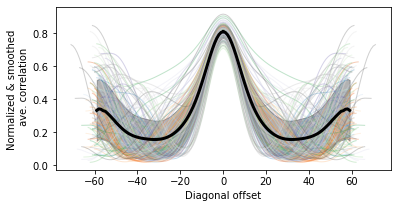

In [7]:
#plot offset and mean_diagonal_sums all together
plt.figure(figsize=(6, 3))
#using cmap to get the color of each line
cmap = plt.get_cmap('tab20c')
#set the color cycle of the plot
plt.gca().set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 1, len(all_offsets.keys()))])
#plot all mean_diagonal_sums


all_half_sum = []
for key in all_offsets.keys():
    Offsets = all_offsets[key]
    mean_diagonal_sums = all_mean_diagonal_sums[key]
    #normalize mean_diagonal_sums to 0 to 1
    mean_diagonal_sums = (mean_diagonal_sums - np.min(mean_diagonal_sums))/(np.max(mean_diagonal_sums) - np.min(mean_diagonal_sums))
    
    #Gaussian smooth the mean_diagonal_sums
    mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=5)
    plt.plot(Offsets, mean_diagonal_sums, alpha=0.3, linewidth=1)
    
    #keep the right half of the mean_diagonal_sums
    half_sum = mean_diagonal_sums[int(len(mean_diagonal_sums)/2):]
    all_half_sum.append(half_sum)
    
#make each elemnt in all_half_sum have the same length, pad np.nan  to the end of the shorter element 
all_half_sum = np.array(all_half_sum)
#max_len = np.max([len(x) for x in all_half_sum])
max_len = 60

all_half_sum = np.array([np.pad(x, (0, max_len-len(x)), 'constant', constant_values=np.nan) if len(x)<max_len else x[:max_len] for x in all_half_sum])
#take nanmean of all_half_sum along the first axis
mean_half_sum = np.nanmean(all_half_sum, axis=0)
#plot mean_half_sum
plt.plot(np.arange(0, len(mean_half_sum)), mean_half_sum, label='mean', linewidth=3, color='k')
#add shaded area of std to the plot
plt.fill_between(np.arange(0, len(mean_half_sum)), mean_half_sum+np.nanstd(all_half_sum, axis=0), mean_half_sum-np.nanstd(all_half_sum, axis=0), alpha=0.3, color='k')
#plot by flipping mean_half_sum to the left side
plt.plot(-np.arange(0, len(mean_half_sum)), mean_half_sum, label='mean', linewidth=3, color='k')
#add shaded area of std to the plot
plt.fill_between(-np.arange(0, len(mean_half_sum)), mean_half_sum+np.nanstd(all_half_sum, axis=0), mean_half_sum-np.nanstd(all_half_sum, axis=0), alpha=0.3, color='k')
plt.xlabel('Diagonal offset')
plt.ylabel('Normalized & smoothed \n ave. correlation')




In [132]:
mean_half_sum

array([1.        , 0.99761864, 0.99013949, 0.97924038, 0.96634508,
       0.95278899, 0.93953759, 0.92714996, 0.9159141 , 0.90595729,
       0.89728749, 0.88982066, 0.88342364, 0.87794993, 0.87326187,
       0.86924437, 0.86579925, 0.862832  , 0.86014465, 0.85754804,
       0.85493564, 0.85233072, 0.84983703, 0.84762049, 0.84540152,
       0.84356965, 0.84179039, 0.84034252, 0.83902345, 0.83794027,
       0.8370309 , 0.83634422, 0.83595862, 0.83571171, 0.83553224,
       0.83544814, 0.83534372, 0.83508326, 0.83470574, 0.83440003,
       0.83400174, 0.83374725, 0.83379174, 0.83421048, 0.83459545,
       0.83588229, 0.83758059, 0.83970056, 0.84228924, 0.84541787,
       0.84908914, 0.85221705, 0.85667531, 0.86045985, 0.86424395,
       0.86659893, 0.86610971, 0.86756409, 0.87086009, 0.87502333,
       0.87508998, 0.86966008, 0.85326012, 0.81854028, 0.8390809 ,
       0.7938554 , 0.7497697 , 0.83790684, 0.80165262, 0.89751921,
       0.97001487, 0.96794469])

In [130]:
all_half_sum.shape

(140, 72)

In [9]:
#get the average sweep length and replay exponent for each epoch
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )


    sweep_len = []
    exponent = []
    intercept = []
    ave_speed = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key  
        
        #print load the model of epoch_key
        print(f"Loading data from {animal}_{day:02d}_{epoch:02d}")
        
        #get the average sweep length and replay exponent       
        mean_immobile_speed, mean_active_speed, mean_sweep_dist, replay_exponent, replay_intercept = get_sweep_and_awake_replay_results(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        
        ave_speed.append(mean_immobile_speed)
        sweep_len.append(mean_sweep_dist)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_sweep_len_peranimal[name] = sweep_len
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept
       

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading data from bon_03_02


epochs:   4%|▍         | 1/24 [00:03<01:28,  3.83s/it]

Average sweep length: 28.694, Diffusion exponent: 0.836
Loading data from bon_03_04


epochs:   8%|▊         | 2/24 [00:06<01:11,  3.26s/it]

Average sweep length: 15.452, Diffusion exponent: 0.840
Loading data from bon_03_06


epochs:  12%|█▎        | 3/24 [00:09<01:04,  3.05s/it]

Average sweep length: 22.764, Diffusion exponent: 0.476
Loading data from bon_04_02


epochs:  17%|█▋        | 4/24 [00:12<01:00,  3.04s/it]

Average sweep length: 18.438, Diffusion exponent: 0.838
Loading data from bon_04_04


epochs:  21%|██        | 5/24 [00:15<00:58,  3.10s/it]

Average sweep length: 17.515, Diffusion exponent: 0.759
Loading data from bon_04_06


epochs:  25%|██▌       | 6/24 [00:18<00:52,  2.91s/it]

Average sweep length: 26.638, Diffusion exponent: 0.643
Loading data from bon_05_02


epochs:  29%|██▉       | 7/24 [00:21<00:49,  2.94s/it]

Average sweep length: 15.255, Diffusion exponent: 0.751
Loading data from bon_05_04


epochs:  33%|███▎      | 8/24 [00:24<00:46,  2.93s/it]

Average sweep length: 14.941, Diffusion exponent: 0.756
Loading data from bon_05_06


epochs:  38%|███▊      | 9/24 [00:27<00:44,  2.98s/it]

Average sweep length: 24.863, Diffusion exponent: 0.616
Loading data from bon_06_02


epochs:  42%|████▏     | 10/24 [00:30<00:41,  3.00s/it]

Average sweep length: 18.539, Diffusion exponent: 0.748
Loading data from bon_06_04


epochs:  46%|████▌     | 11/24 [00:33<00:37,  2.92s/it]

Average sweep length: 15.474, Diffusion exponent: 0.661
Loading data from bon_06_06


epochs:  50%|█████     | 12/24 [00:35<00:33,  2.80s/it]

Average sweep length: 23.922, Diffusion exponent: 0.577
Loading data from bon_07_02


epochs:  54%|█████▍    | 13/24 [00:38<00:31,  2.86s/it]

Average sweep length: 16.487, Diffusion exponent: 0.710
Loading data from bon_07_04


epochs:  58%|█████▊    | 14/24 [00:41<00:28,  2.84s/it]

Average sweep length: 13.139, Diffusion exponent: 0.617
Loading data from bon_07_06


epochs:  62%|██████▎   | 15/24 [00:43<00:24,  2.73s/it]

Average sweep length: 23.875, Diffusion exponent: 0.560
Loading data from bon_08_02


epochs:  67%|██████▋   | 16/24 [00:46<00:21,  2.68s/it]

Average sweep length: 14.454, Diffusion exponent: 0.795
Loading data from bon_08_04


epochs:  71%|███████   | 17/24 [00:48<00:18,  2.63s/it]

Average sweep length: 15.309, Diffusion exponent: 0.700
Loading data from bon_08_06


epochs:  75%|███████▌  | 18/24 [00:51<00:15,  2.61s/it]

Average sweep length: 16.225, Diffusion exponent: 0.587
Loading data from bon_09_02


epochs:  79%|███████▉  | 19/24 [00:53<00:12,  2.55s/it]

Average sweep length: 16.699, Diffusion exponent: 0.738
Loading data from bon_09_04


epochs:  83%|████████▎ | 20/24 [00:56<00:10,  2.51s/it]

Average sweep length: 12.199, Diffusion exponent: 0.717
Loading data from bon_09_06


epochs:  88%|████████▊ | 21/24 [00:58<00:07,  2.54s/it]

Average sweep length: 21.473, Diffusion exponent: 0.525
Loading data from bon_10_02


epochs:  92%|█████████▏| 22/24 [01:01<00:04,  2.44s/it]

Average sweep length: 13.744, Diffusion exponent: 0.734
Loading data from bon_10_04


epochs:  96%|█████████▌| 23/24 [01:03<00:02,  2.33s/it]

Average sweep length: 11.304, Diffusion exponent: 0.658
Loading data from bon_10_06


epochs: 100%|██████████| 24/24 [01:05<00:00,  2.73s/it]


Average sweep length: 18.566, Diffusion exponent: 0.547


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Loading data from fra_04_02


epochs:   4%|▎         | 1/27 [00:02<01:14,  2.86s/it]

Average sweep length: 20.092, Diffusion exponent: 0.813
Loading data from fra_04_04


epochs:   7%|▋         | 2/27 [00:05<01:01,  2.47s/it]

Average sweep length: 17.059, Diffusion exponent: 0.755
Loading data from fra_04_06


epochs:  11%|█         | 3/27 [00:07<00:54,  2.27s/it]

Average sweep length: 18.628, Diffusion exponent: 0.570
Loading data from fra_05_02


epochs:  15%|█▍        | 4/27 [00:09<00:56,  2.47s/it]

Average sweep length: 29.320, Diffusion exponent: 0.723
Loading data from fra_05_04


epochs:  19%|█▊        | 5/27 [00:12<00:56,  2.55s/it]

Average sweep length: 22.498, Diffusion exponent: 0.748
Loading data from fra_05_06


epochs:  22%|██▏       | 6/27 [00:14<00:49,  2.37s/it]

Average sweep length: 17.249, Diffusion exponent: 0.652
Loading data from fra_06_02


epochs:  26%|██▌       | 7/27 [00:17<00:49,  2.45s/it]

Average sweep length: 20.728, Diffusion exponent: 0.775
Loading data from fra_06_04


epochs:  30%|██▉       | 8/27 [00:19<00:46,  2.46s/it]

Average sweep length: 19.103, Diffusion exponent: 0.802
Loading data from fra_06_06


epochs:  33%|███▎      | 9/27 [00:22<00:44,  2.50s/it]

Average sweep length: 15.996, Diffusion exponent: 0.559
Loading data from fra_07_02


epochs:  37%|███▋      | 10/27 [00:23<00:37,  2.20s/it]

Average sweep length: 17.274, Diffusion exponent: 0.778
Loading data from fra_07_04


epochs:  41%|████      | 11/27 [00:26<00:36,  2.31s/it]

Average sweep length: 15.934, Diffusion exponent: 0.735
Loading data from fra_07_06


epochs:  44%|████▍     | 12/27 [00:28<00:34,  2.31s/it]

Average sweep length: 16.062, Diffusion exponent: 0.564
Loading data from fra_08_02


epochs:  48%|████▊     | 13/27 [00:31<00:33,  2.40s/it]

Average sweep length: 17.907, Diffusion exponent: 0.756
Loading data from fra_08_04


epochs:  52%|█████▏    | 14/27 [00:33<00:31,  2.44s/it]

Average sweep length: 12.584, Diffusion exponent: 0.701
Loading data from fra_08_06


epochs:  56%|█████▌    | 15/27 [00:35<00:27,  2.25s/it]

Average sweep length: 14.497, Diffusion exponent: 0.570
Loading data from fra_09_02


epochs:  59%|█████▉    | 16/27 [00:38<00:25,  2.36s/it]

Average sweep length: 15.298, Diffusion exponent: 0.803
Loading data from fra_09_04


epochs:  63%|██████▎   | 17/27 [00:40<00:23,  2.34s/it]

Average sweep length: 12.837, Diffusion exponent: 0.713
Loading data from fra_09_06


epochs:  67%|██████▋   | 18/27 [00:42<00:20,  2.25s/it]

Average sweep length: 14.075, Diffusion exponent: 0.589
Loading data from fra_10_02


epochs:  70%|███████   | 19/27 [00:44<00:18,  2.28s/it]

Average sweep length: 16.093, Diffusion exponent: 0.673
Loading data from fra_10_04


epochs:  74%|███████▍  | 20/27 [00:47<00:16,  2.29s/it]

Average sweep length: 12.459, Diffusion exponent: 0.725
Loading data from fra_10_06


epochs:  78%|███████▊  | 21/27 [00:49<00:12,  2.13s/it]

Average sweep length: 12.184, Diffusion exponent: 0.566
Loading data from fra_11_02


epochs:  81%|████████▏ | 22/27 [00:51<00:11,  2.27s/it]

Average sweep length: 25.873, Diffusion exponent: 0.733
Loading data from fra_11_04


epochs:  85%|████████▌ | 23/27 [00:53<00:09,  2.28s/it]

Average sweep length: 23.833, Diffusion exponent: 0.777
Loading data from fra_11_06


epochs:  89%|████████▉ | 24/27 [00:55<00:06,  2.21s/it]

Average sweep length: 22.067, Diffusion exponent: 0.528
Loading data from fra_12_02


epochs:  93%|█████████▎| 25/27 [00:57<00:04,  2.12s/it]

Average sweep length: 14.216, Diffusion exponent: 0.750
Loading data from fra_12_04


epochs:  96%|█████████▋| 26/27 [00:59<00:02,  2.08s/it]

Average sweep length: 27.171, Diffusion exponent: 0.784
Loading data from fra_12_06


epochs: 100%|██████████| 27/27 [01:01<00:00,  2.28s/it]


Average sweep length: 19.336, Diffusion exponent: 0.634


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Loading data from gov_06_02


epochs:   4%|▍         | 1/24 [00:03<01:26,  3.78s/it]

Average sweep length: 42.181, Diffusion exponent: 0.770
Loading data from gov_06_04


epochs:   8%|▊         | 2/24 [00:07<01:22,  3.77s/it]

Average sweep length: 38.538, Diffusion exponent: 0.834
Loading data from gov_06_06


epochs:  12%|█▎        | 3/24 [00:11<01:18,  3.73s/it]

Average sweep length: 31.102, Diffusion exponent: 0.765
Loading data from gov_07_02


epochs:  17%|█▋        | 4/24 [00:14<01:13,  3.66s/it]

Average sweep length: 30.097, Diffusion exponent: 0.792
Loading data from gov_07_04


epochs:  21%|██        | 5/24 [00:18<01:07,  3.56s/it]

Average sweep length: 23.374, Diffusion exponent: 0.771
Loading data from gov_07_06


epochs:  25%|██▌       | 6/24 [00:21<01:05,  3.63s/it]

Average sweep length: 32.112, Diffusion exponent: 0.857
Loading data from gov_08_02


epochs:  29%|██▉       | 7/24 [00:25<01:01,  3.59s/it]

Average sweep length: 27.411, Diffusion exponent: 0.782
Loading data from gov_08_04


epochs:  33%|███▎      | 8/24 [00:29<00:57,  3.59s/it]

Average sweep length: 24.466, Diffusion exponent: 0.810
Loading data from gov_08_06


epochs:  38%|███▊      | 9/24 [00:32<00:54,  3.60s/it]

Average sweep length: 31.787, Diffusion exponent: 0.662
Loading data from gov_09_02


epochs:  42%|████▏     | 10/24 [00:36<00:52,  3.74s/it]

Average sweep length: 40.371, Diffusion exponent: 0.772
Loading data from gov_09_03


epochs:  46%|████▌     | 11/24 [00:40<00:48,  3.69s/it]

Average sweep length: 24.728, Diffusion exponent: 0.713
Loading data from gov_09_05


epochs:  50%|█████     | 12/24 [00:44<00:45,  3.78s/it]

Average sweep length: 34.040, Diffusion exponent: 0.789
Loading data from gov_10_02


epochs:  54%|█████▍    | 13/24 [00:48<00:43,  3.97s/it]

Average sweep length: 54.398, Diffusion exponent: 0.915
Loading data from gov_10_04


epochs:  58%|█████▊    | 14/24 [00:52<00:39,  3.92s/it]

Average sweep length: 38.031, Diffusion exponent: 0.812
Loading data from gov_10_06


epochs:  62%|██████▎   | 15/24 [00:56<00:34,  3.86s/it]

Average sweep length: 38.866, Diffusion exponent: 0.798
Loading data from gov_11_02


epochs:  67%|██████▋   | 16/24 [01:00<00:31,  3.88s/it]

Average sweep length: 42.671, Diffusion exponent: 0.807
Loading data from gov_11_04


epochs:  71%|███████   | 17/24 [01:03<00:27,  3.87s/it]

Average sweep length: 47.112, Diffusion exponent: 0.816
Loading data from gov_11_06


epochs:  75%|███████▌  | 18/24 [01:07<00:22,  3.75s/it]

Average sweep length: 33.810, Diffusion exponent: 0.795
Loading data from gov_12_02


epochs:  79%|███████▉  | 19/24 [01:11<00:19,  3.84s/it]

Average sweep length: 39.809, Diffusion exponent: 0.769
Loading data from gov_12_04


epochs:  83%|████████▎ | 20/24 [01:15<00:15,  3.85s/it]

Average sweep length: 33.791, Diffusion exponent: 0.804
Loading data from gov_12_06


epochs:  88%|████████▊ | 21/24 [01:18<00:11,  3.72s/it]

Average sweep length: 35.173, Diffusion exponent: 0.775
Loading data from gov_13_02


epochs:  92%|█████████▏| 22/24 [01:22<00:07,  3.63s/it]

Average sweep length: 41.276, Diffusion exponent: 0.935
Loading data from gov_13_04


epochs:  96%|█████████▌| 23/24 [01:25<00:03,  3.63s/it]

Average sweep length: 39.326, Diffusion exponent: 0.914
Loading data from gov_13_06


epochs: 100%|██████████| 24/24 [01:29<00:00,  3.73s/it]


Average sweep length: 35.406, Diffusion exponent: 0.846


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Loading data from dud_02_02


epochs:  50%|█████     | 1/2 [00:03<00:03,  3.44s/it]

Average sweep length: 51.268, Diffusion exponent: 0.792
Loading data from dud_05_02


epochs: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Average sweep length: 41.509, Diffusion exponent: 0.810


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Loading data from con_01_02


epochs:   7%|▋         | 1/15 [00:03<00:43,  3.11s/it]

Average sweep length: 29.336, Diffusion exponent: 0.803
Loading data from con_01_04


epochs:  13%|█▎        | 2/15 [00:06<00:40,  3.15s/it]

Average sweep length: 21.269, Diffusion exponent: 0.903
Loading data from con_02_02


epochs:  20%|██        | 3/15 [00:09<00:37,  3.16s/it]

Average sweep length: 25.001, Diffusion exponent: 1.084
Loading data from con_02_04


epochs:  27%|██▋       | 4/15 [00:12<00:34,  3.17s/it]

Average sweep length: 22.739, Diffusion exponent: 0.931
Loading data from con_03_02


epochs:  33%|███▎      | 5/15 [00:16<00:32,  3.25s/it]

Average sweep length: 26.488, Diffusion exponent: 0.955
Loading data from con_03_04


epochs:  40%|████      | 6/15 [00:18<00:27,  3.06s/it]

Average sweep length: 20.019, Diffusion exponent: 0.953
Loading data from con_04_02


epochs:  47%|████▋     | 7/15 [00:22<00:27,  3.45s/it]

Average sweep length: 25.689, Diffusion exponent: 0.629
Loading data from con_04_04


epochs:  53%|█████▎    | 8/15 [00:25<00:23,  3.29s/it]

Average sweep length: 22.011, Diffusion exponent: 0.902
Loading data from con_04_06


epochs:  60%|██████    | 9/15 [00:28<00:19,  3.22s/it]

Average sweep length: 19.763, Diffusion exponent: 0.602
Loading data from con_05_02


epochs:  67%|██████▋   | 10/15 [00:32<00:16,  3.28s/it]

Average sweep length: 21.089, Diffusion exponent: 0.914
Loading data from con_05_04


epochs:  73%|███████▎  | 11/15 [00:35<00:12,  3.25s/it]

Average sweep length: 19.997, Diffusion exponent: 0.767
Loading data from con_05_06


epochs:  80%|████████  | 12/15 [00:38<00:09,  3.18s/it]

Average sweep length: 22.697, Diffusion exponent: 0.643
Loading data from con_06_02


epochs:  87%|████████▋ | 13/15 [00:41<00:06,  3.20s/it]

Average sweep length: 26.482, Diffusion exponent: 0.519
Loading data from con_06_04


epochs:  93%|█████████▎| 14/15 [00:45<00:03,  3.28s/it]

Average sweep length: 22.143, Diffusion exponent: 1.017
Loading data from con_06_06


epochs: 100%|██████████| 15/15 [00:48<00:00,  3.26s/it]


Average sweep length: 25.380, Diffusion exponent: 0.913


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Loading data from dav_03_02


epochs:   7%|▋         | 1/15 [00:04<00:58,  4.15s/it]

Average sweep length: 37.958, Diffusion exponent: 0.864
Loading data from dav_03_04


epochs:  13%|█▎        | 2/15 [00:07<00:51,  3.93s/it]

Average sweep length: 31.233, Diffusion exponent: 0.761
Loading data from dav_03_06


epochs:  20%|██        | 3/15 [00:11<00:47,  3.95s/it]

Average sweep length: 33.076, Diffusion exponent: 0.865
Loading data from dav_04_02


epochs:  27%|██▋       | 4/15 [00:15<00:42,  3.89s/it]

Average sweep length: 45.286, Diffusion exponent: 0.811
Loading data from dav_04_04


epochs:  33%|███▎      | 5/15 [00:19<00:37,  3.75s/it]

Average sweep length: 28.193, Diffusion exponent: 0.860
Loading data from dav_04_06


epochs:  40%|████      | 6/15 [00:22<00:33,  3.72s/it]

Average sweep length: 26.897, Diffusion exponent: 0.812
Loading data from dav_05_03


epochs:  47%|████▋     | 7/15 [00:26<00:28,  3.59s/it]

Average sweep length: 37.314, Diffusion exponent: 0.823
Loading data from dav_06_02


epochs:  53%|█████▎    | 8/15 [00:30<00:25,  3.68s/it]

Average sweep length: 32.341, Diffusion exponent: 0.781
Loading data from dav_06_04


epochs:  60%|██████    | 9/15 [00:33<00:21,  3.56s/it]

Average sweep length: 22.005, Diffusion exponent: 0.911
Loading data from dav_06_06


epochs:  67%|██████▋   | 10/15 [00:36<00:17,  3.51s/it]

Average sweep length: 27.046, Diffusion exponent: 0.752
Loading data from dav_07_02


epochs:  73%|███████▎  | 11/15 [00:39<00:12,  3.17s/it]

Average sweep length: 27.716, Diffusion exponent: 0.810
Loading data from dav_07_03


epochs:  80%|████████  | 12/15 [00:41<00:08,  2.85s/it]

Average sweep length: 27.773, Diffusion exponent: 0.770
Loading data from dav_07_05


epochs:  87%|████████▋ | 13/15 [00:44<00:05,  2.99s/it]

Average sweep length: 21.816, Diffusion exponent: 0.869
Loading data from dav_07_07


epochs:  93%|█████████▎| 14/15 [00:48<00:03,  3.20s/it]

Average sweep length: 22.278, Diffusion exponent: 0.770
Loading data from dav_07_09


epochs: 100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


Average sweep length: 31.151, Diffusion exponent: 0.866


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Loading data from Cor_01_02


epochs:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

Average sweep length: 47.554, Diffusion exponent: 0.781
Loading data from Cor_01_04


epochs:  20%|██        | 2/10 [00:04<00:17,  2.23s/it]

Average sweep length: 26.151, Diffusion exponent: 0.863
Loading data from Cor_02_02


epochs:  30%|███       | 3/10 [00:07<00:17,  2.52s/it]

Average sweep length: 27.537, Diffusion exponent: 0.774
Loading data from Cor_02_04


epochs:  40%|████      | 4/10 [00:09<00:13,  2.31s/it]

Average sweep length: 25.822, Diffusion exponent: 0.703
Loading data from Cor_03_02


epochs:  50%|█████     | 5/10 [00:11<00:11,  2.34s/it]

Average sweep length: 27.993, Diffusion exponent: 0.745
Loading data from Cor_03_04


epochs:  60%|██████    | 6/10 [00:13<00:09,  2.31s/it]

Average sweep length: 23.716, Diffusion exponent: 0.816
Loading data from Cor_04_02


epochs:  70%|███████   | 7/10 [00:16<00:07,  2.45s/it]

Average sweep length: 27.034, Diffusion exponent: 0.798
Loading data from Cor_04_04


epochs:  80%|████████  | 8/10 [00:19<00:05,  2.51s/it]

Average sweep length: 70.488, Diffusion exponent: 0.780
Loading data from Cor_07_02


epochs:  90%|█████████ | 9/10 [00:21<00:02,  2.56s/it]

Average sweep length: 24.679, Diffusion exponent: 0.807
Loading data from Cor_08_02


epochs: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


Average sweep length: 32.787, Diffusion exponent: 0.730


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Loading data from egy_05_02


epochs:   5%|▌         | 1/19 [00:03<01:10,  3.89s/it]

Average sweep length: 30.278, Diffusion exponent: 0.800
Loading data from egy_05_04


epochs:  11%|█         | 2/19 [00:07<01:02,  3.66s/it]

Average sweep length: 26.949, Diffusion exponent: 0.868
Loading data from egy_05_06


epochs:  16%|█▌        | 3/19 [00:10<00:56,  3.56s/it]

Average sweep length: 29.352, Diffusion exponent: 0.730
Loading data from egy_06_04


epochs:  21%|██        | 4/19 [00:14<00:55,  3.68s/it]

Average sweep length: 38.525, Diffusion exponent: 0.856
Loading data from egy_06_07


epochs:  26%|██▋       | 5/19 [00:18<00:51,  3.68s/it]

Average sweep length: 33.940, Diffusion exponent: 0.805
Loading data from egy_07_02


epochs:  32%|███▏      | 6/19 [00:21<00:46,  3.56s/it]

Average sweep length: 38.709, Diffusion exponent: 0.810
Loading data from egy_07_04


epochs:  37%|███▋      | 7/19 [00:25<00:42,  3.51s/it]

Average sweep length: 34.899, Diffusion exponent: 0.826
Loading data from egy_07_06


epochs:  42%|████▏     | 8/19 [00:28<00:36,  3.36s/it]

Average sweep length: 53.380, Diffusion exponent: 0.805
Loading data from egy_08_02


epochs:  47%|████▋     | 9/19 [00:31<00:33,  3.37s/it]

Average sweep length: 37.534, Diffusion exponent: 0.848
Loading data from egy_08_04


epochs:  53%|█████▎    | 10/19 [00:34<00:30,  3.38s/it]

Average sweep length: 48.738, Diffusion exponent: 0.775
Loading data from egy_08_06


epochs:  58%|█████▊    | 11/19 [00:38<00:27,  3.42s/it]

Average sweep length: 31.795, Diffusion exponent: 0.868
Loading data from egy_09_02


epochs:  63%|██████▎   | 12/19 [00:42<00:24,  3.47s/it]

Average sweep length: 44.117, Diffusion exponent: 0.825
Loading data from egy_09_04


epochs:  68%|██████▊   | 13/19 [00:45<00:20,  3.44s/it]

Average sweep length: 43.357, Diffusion exponent: 0.785
Loading data from egy_10_02


epochs:  74%|███████▎  | 14/19 [00:48<00:17,  3.48s/it]

Average sweep length: 28.652, Diffusion exponent: 0.857
Loading data from egy_10_04


epochs:  79%|███████▉  | 15/19 [00:52<00:13,  3.50s/it]

Average sweep length: 26.712, Diffusion exponent: 0.788
Loading data from egy_10_06


epochs:  84%|████████▍ | 16/19 [00:56<00:10,  3.50s/it]

Average sweep length: 34.490, Diffusion exponent: 0.785
Loading data from egy_11_02


epochs:  89%|████████▉ | 17/19 [00:59<00:07,  3.53s/it]

Average sweep length: 41.875, Diffusion exponent: 0.782
Loading data from egy_11_04


epochs:  95%|█████████▍| 18/19 [01:02<00:03,  3.45s/it]

Average sweep length: 39.779, Diffusion exponent: 0.767
Loading data from egy_11_06


epochs: 100%|██████████| 19/19 [01:06<00:00,  3.49s/it]


Average sweep length: 40.379, Diffusion exponent: 0.826


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data from cha_04_02


epochs:  25%|██▌       | 1/4 [00:03<00:11,  3.96s/it]

Average sweep length: 50.093, Diffusion exponent: 0.727
Loading data from cha_04_04


epochs:  50%|█████     | 2/4 [00:07<00:07,  3.74s/it]

Average sweep length: 46.601, Diffusion exponent: 0.583
Loading data from cha_08_02


epochs:  75%|███████▌  | 3/4 [00:11<00:03,  3.66s/it]

Average sweep length: 50.168, Diffusion exponent: 0.572
Loading data from cha_08_04


epochs: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]

Average sweep length: 40.948, Diffusion exponent: 0.668


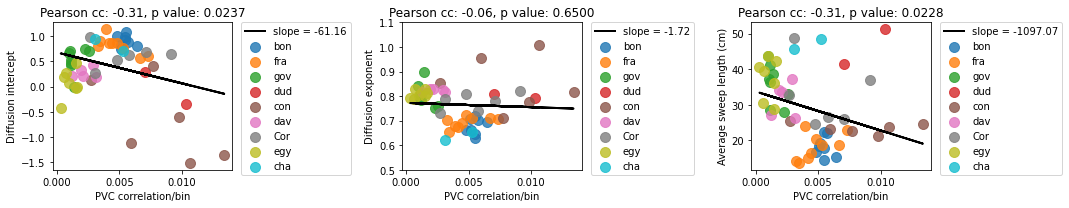

In [13]:
#plot width against replay_exponent for each animal, each with different color in subplot 1
#using all_width_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
all_corrbin_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    all_corrbin_perday_ave[key] = np.mean(all_corrbin_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
all_corrbin_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
    all_corrbin_perday_concat.setdefault(key[0], []).append(all_corrbin_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(15,3))

plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, intercept_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion intercept')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#intercept
plt.subplot(1,3,2)

#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(1,3,3)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_sweep_len_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Average sweep length (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


In [21]:
#save the results fpr paper plots using pickle
#results to be saved are as follows:
# all_offsets
# all_mean_diagonal_sums
# all_corr_matrix
# all_unique_nan_index
# animal_names
# all_corrbin_perday_concat
# all_sweep_len_perday_concat
# all_exponent_perday_concat

import pickle
with open('./sweep_replay_correlation_with_PVC.pickle', 'wb') as f:
    pickle.dump([all_offsets, all_mean_diagonal_sums, all_corr_matrix, all_unique_nan_index, animal_names, all_corrbin_perday_concat, all_sweep_len_perday_concat, all_exponent_perday_concat], f)

In [11]:
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_peak_sweep_len_peranimal = {}; all_peak_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
all_ave_activespeed_peranimal = {}; all_ave_activespeed_perday = {}
all_behav_exponent_peranimal = {}; all_behav_exponent_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )

    # #add remy 37 4 to the valid_epochs since this is the only valid epoch for remy. 
    # #generally data for remy was stored differently from other animals
    # valid_epochs[('remy', 37, 4)] = True
    
    sweep_len = []
    peak_sweep_len = []
    exponent = []
    intercept = []
    ave_speed = []
    ave_activespeed = []
    behav_exponent = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue
        
        if (animal, day, epoch) == ('bon', 4, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        #get the average sweep length and replay exponent
        mean_immobile_speed, mean_active_speed, behav_exp, mean_sweep_dist, mean_peak_sweep_dist_in_theta, replay_exponent, replay_intercept = get_sweep_and_awake_replay_results_using_postive_negative_peak_in_LFP(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        # print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        print(f'Average sweep length: {mean_sweep_dist:.3f}, average peak sweep length in theta: {mean_peak_sweep_dist_in_theta:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_peak_sweep_len_perday.setdefault((animal, day), []).append(mean_peak_sweep_dist_in_theta)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        all_ave_activespeed_perday.setdefault((animal, day), []).append(mean_active_speed)
        all_behav_exponent_perday.setdefault((animal, day), []).append(behav_exp)
        
        ave_speed.append(mean_immobile_speed)
        ave_activespeed.append(mean_active_speed)
        behav_exponent.append(behav_exp)
        sweep_len.append(mean_sweep_dist)
        peak_sweep_len.append(mean_peak_sweep_dist_in_theta)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_ave_activespeed_peranimal[name] = ave_activespeed
    all_behav_exponent_peranimal[name] = behav_exponent
    all_sweep_len_peranimal[name] = sweep_len
    all_peak_sweep_len_peranimal[name] = peak_sweep_len
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2


epochs:   4%|▍         | 1/24 [00:07<02:52,  7.49s/it]

Average sweep length: 28.694, average peak sweep length in theta: 49.932, Diffusion exponent: 0.836
Animal: bon, Day: 3, Epoch: 4


epochs:   8%|▊         | 2/24 [00:13<02:23,  6.51s/it]

Average sweep length: 15.452, average peak sweep length in theta: 34.348, Diffusion exponent: 0.840
Animal: bon, Day: 3, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:18<02:05,  6.00s/it]

Average sweep length: 22.764, average peak sweep length in theta: 43.452, Diffusion exponent: 0.476
Animal: bon, Day: 4, Epoch: 4


epochs:  21%|██        | 5/24 [00:24<01:22,  4.32s/it]

Average sweep length: 17.515, average peak sweep length in theta: 35.363, Diffusion exponent: 0.759
Animal: bon, Day: 4, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:29<01:21,  4.54s/it]

Average sweep length: 26.638, average peak sweep length in theta: 44.658, Diffusion exponent: 0.643
Animal: bon, Day: 5, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:35<01:24,  4.95s/it]

Average sweep length: 15.255, average peak sweep length in theta: 33.390, Diffusion exponent: 0.751
Animal: bon, Day: 5, Epoch: 4


epochs:  33%|███▎      | 8/24 [00:41<01:23,  5.20s/it]

Average sweep length: 14.941, average peak sweep length in theta: 31.837, Diffusion exponent: 0.756
Animal: bon, Day: 5, Epoch: 6


epochs:  38%|███▊      | 9/24 [00:47<01:22,  5.47s/it]

Average sweep length: 24.863, average peak sweep length in theta: 38.404, Diffusion exponent: 0.616
Animal: bon, Day: 6, Epoch: 2


epochs:  42%|████▏     | 10/24 [00:53<01:18,  5.60s/it]

Average sweep length: 18.539, average peak sweep length in theta: 36.235, Diffusion exponent: 0.748
Animal: bon, Day: 6, Epoch: 4


epochs:  46%|████▌     | 11/24 [00:58<01:11,  5.51s/it]

Average sweep length: 15.474, average peak sweep length in theta: 32.402, Diffusion exponent: 0.661
Animal: bon, Day: 6, Epoch: 6


epochs:  50%|█████     | 12/24 [01:03<01:04,  5.34s/it]

Average sweep length: 23.922, average peak sweep length in theta: 42.844, Diffusion exponent: 0.577
Animal: bon, Day: 7, Epoch: 2


epochs:  54%|█████▍    | 13/24 [01:09<00:59,  5.41s/it]

Average sweep length: 16.487, average peak sweep length in theta: 34.842, Diffusion exponent: 0.710
Animal: bon, Day: 7, Epoch: 4


epochs:  58%|█████▊    | 14/24 [01:14<00:53,  5.36s/it]

Average sweep length: 13.139, average peak sweep length in theta: 31.495, Diffusion exponent: 0.617
Animal: bon, Day: 7, Epoch: 6


epochs:  62%|██████▎   | 15/24 [01:19<00:46,  5.20s/it]

Average sweep length: 23.875, average peak sweep length in theta: 39.828, Diffusion exponent: 0.560
Animal: bon, Day: 8, Epoch: 2


epochs:  67%|██████▋   | 16/24 [01:24<00:41,  5.16s/it]

Average sweep length: 14.454, average peak sweep length in theta: 32.679, Diffusion exponent: 0.795
Animal: bon, Day: 8, Epoch: 4


epochs:  71%|███████   | 17/24 [01:29<00:35,  5.08s/it]

Average sweep length: 15.309, average peak sweep length in theta: 34.690, Diffusion exponent: 0.700
Animal: bon, Day: 8, Epoch: 6


epochs:  75%|███████▌  | 18/24 [01:34<00:30,  5.04s/it]

Average sweep length: 16.225, average peak sweep length in theta: 36.783, Diffusion exponent: 0.587
Animal: bon, Day: 9, Epoch: 2


epochs:  79%|███████▉  | 19/24 [01:39<00:24,  4.92s/it]

Average sweep length: 16.699, average peak sweep length in theta: 34.632, Diffusion exponent: 0.738
Animal: bon, Day: 9, Epoch: 4


epochs:  83%|████████▎ | 20/24 [01:43<00:19,  4.90s/it]

Average sweep length: 12.199, average peak sweep length in theta: 28.893, Diffusion exponent: 0.717
Animal: bon, Day: 9, Epoch: 6


epochs:  88%|████████▊ | 21/24 [01:49<00:14,  4.99s/it]

Average sweep length: 21.473, average peak sweep length in theta: 38.343, Diffusion exponent: 0.525
Animal: bon, Day: 10, Epoch: 2


epochs:  92%|█████████▏| 22/24 [01:53<00:09,  4.79s/it]

Average sweep length: 13.744, average peak sweep length in theta: 32.099, Diffusion exponent: 0.734
Animal: bon, Day: 10, Epoch: 4


epochs:  96%|█████████▌| 23/24 [01:57<00:04,  4.57s/it]

Average sweep length: 11.304, average peak sweep length in theta: 27.154, Diffusion exponent: 0.658
Animal: bon, Day: 10, Epoch: 6


epochs: 100%|██████████| 24/24 [02:02<00:00,  5.10s/it]


Average sweep length: 18.566, average peak sweep length in theta: 36.644, Diffusion exponent: 0.547


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 4, Epoch: 2


epochs:   4%|▎         | 1/27 [00:05<02:18,  5.34s/it]

Average sweep length: 20.092, average peak sweep length in theta: 44.356, Diffusion exponent: 0.813
Animal: fra, Day: 4, Epoch: 4


epochs:   7%|▋         | 2/27 [00:09<01:56,  4.65s/it]

Average sweep length: 17.059, average peak sweep length in theta: 39.451, Diffusion exponent: 0.755
Animal: fra, Day: 4, Epoch: 6


epochs:  11%|█         | 3/27 [00:13<01:42,  4.28s/it]

Average sweep length: 18.628, average peak sweep length in theta: 39.858, Diffusion exponent: 0.570
Animal: fra, Day: 5, Epoch: 2


epochs:  15%|█▍        | 4/27 [00:18<01:47,  4.67s/it]

Average sweep length: 29.320, average peak sweep length in theta: 47.984, Diffusion exponent: 0.723
Animal: fra, Day: 5, Epoch: 4


epochs:  19%|█▊        | 5/27 [00:23<01:46,  4.83s/it]

Average sweep length: 22.498, average peak sweep length in theta: 40.953, Diffusion exponent: 0.748
Animal: fra, Day: 5, Epoch: 6


epochs:  22%|██▏       | 6/27 [00:27<01:33,  4.47s/it]

Average sweep length: 17.249, average peak sweep length in theta: 37.472, Diffusion exponent: 0.652
Animal: fra, Day: 6, Epoch: 2


epochs:  26%|██▌       | 7/27 [00:32<01:32,  4.65s/it]

Average sweep length: 20.728, average peak sweep length in theta: 39.598, Diffusion exponent: 0.775
Animal: fra, Day: 6, Epoch: 4


epochs:  30%|██▉       | 8/27 [00:37<01:28,  4.64s/it]

Average sweep length: 19.103, average peak sweep length in theta: 38.934, Diffusion exponent: 0.802
Animal: fra, Day: 6, Epoch: 6


epochs:  33%|███▎      | 9/27 [00:42<01:24,  4.72s/it]

Average sweep length: 15.996, average peak sweep length in theta: 33.698, Diffusion exponent: 0.559
Animal: fra, Day: 7, Epoch: 2


epochs:  37%|███▋      | 10/27 [00:45<01:11,  4.19s/it]

Average sweep length: 17.274, average peak sweep length in theta: 38.233, Diffusion exponent: 0.778
Animal: fra, Day: 7, Epoch: 4


epochs:  41%|████      | 11/27 [00:49<01:10,  4.39s/it]

Average sweep length: 15.934, average peak sweep length in theta: 34.369, Diffusion exponent: 0.735
Animal: fra, Day: 7, Epoch: 6


epochs:  44%|████▍     | 12/27 [00:54<01:05,  4.38s/it]

Average sweep length: 16.062, average peak sweep length in theta: 34.078, Diffusion exponent: 0.564
Animal: fra, Day: 8, Epoch: 2


epochs:  48%|████▊     | 13/27 [00:59<01:03,  4.53s/it]

Average sweep length: 17.907, average peak sweep length in theta: 35.555, Diffusion exponent: 0.756
Animal: fra, Day: 8, Epoch: 4


epochs:  52%|█████▏    | 14/27 [01:03<00:59,  4.60s/it]

Average sweep length: 12.584, average peak sweep length in theta: 29.440, Diffusion exponent: 0.701
Animal: fra, Day: 8, Epoch: 6


epochs:  56%|█████▌    | 15/27 [01:07<00:51,  4.26s/it]

Average sweep length: 14.497, average peak sweep length in theta: 32.973, Diffusion exponent: 0.570
Animal: fra, Day: 9, Epoch: 2


epochs:  59%|█████▉    | 16/27 [01:12<00:48,  4.45s/it]

Average sweep length: 15.298, average peak sweep length in theta: 32.783, Diffusion exponent: 0.803
Animal: fra, Day: 9, Epoch: 4


epochs:  63%|██████▎   | 17/27 [01:16<00:44,  4.44s/it]

Average sweep length: 12.837, average peak sweep length in theta: 30.509, Diffusion exponent: 0.713
Animal: fra, Day: 9, Epoch: 6


epochs:  67%|██████▋   | 18/27 [01:20<00:38,  4.29s/it]

Average sweep length: 14.075, average peak sweep length in theta: 32.161, Diffusion exponent: 0.589
Animal: fra, Day: 10, Epoch: 2


epochs:  70%|███████   | 19/27 [01:25<00:34,  4.33s/it]

Average sweep length: 16.093, average peak sweep length in theta: 35.216, Diffusion exponent: 0.673
Animal: fra, Day: 10, Epoch: 4


epochs:  74%|███████▍  | 20/27 [01:29<00:30,  4.36s/it]

Average sweep length: 12.459, average peak sweep length in theta: 29.986, Diffusion exponent: 0.725
Animal: fra, Day: 10, Epoch: 6


epochs:  78%|███████▊  | 21/27 [01:32<00:24,  4.05s/it]

Average sweep length: 12.184, average peak sweep length in theta: 28.332, Diffusion exponent: 0.566
Animal: fra, Day: 11, Epoch: 2


epochs:  81%|████████▏ | 22/27 [01:37<00:21,  4.28s/it]

Average sweep length: 25.873, average peak sweep length in theta: 41.205, Diffusion exponent: 0.733
Animal: fra, Day: 11, Epoch: 4


epochs:  85%|████████▌ | 23/27 [01:41<00:17,  4.28s/it]

Average sweep length: 23.833, average peak sweep length in theta: 41.806, Diffusion exponent: 0.777
Animal: fra, Day: 11, Epoch: 6


epochs:  89%|████████▉ | 24/27 [01:45<00:12,  4.18s/it]

Average sweep length: 22.067, average peak sweep length in theta: 39.101, Diffusion exponent: 0.528
Animal: fra, Day: 12, Epoch: 2


epochs:  93%|█████████▎| 25/27 [01:49<00:08,  4.03s/it]

Average sweep length: 14.216, average peak sweep length in theta: 29.094, Diffusion exponent: 0.750
Animal: fra, Day: 12, Epoch: 4


epochs:  96%|█████████▋| 26/27 [01:53<00:03,  3.97s/it]

Average sweep length: 27.171, average peak sweep length in theta: 42.501, Diffusion exponent: 0.784
Animal: fra, Day: 12, Epoch: 6


epochs: 100%|██████████| 27/27 [01:56<00:00,  4.33s/it]


Average sweep length: 19.336, average peak sweep length in theta: 35.901, Diffusion exponent: 0.634


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2


epochs:   4%|▍         | 1/24 [00:06<02:35,  6.76s/it]

Average sweep length: 42.181, average peak sweep length in theta: 63.321, Diffusion exponent: 0.770
Animal: gov, Day: 6, Epoch: 4


epochs:   8%|▊         | 2/24 [00:13<02:28,  6.73s/it]

Average sweep length: 38.538, average peak sweep length in theta: 53.624, Diffusion exponent: 0.834
Animal: gov, Day: 6, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:20<02:20,  6.67s/it]

Average sweep length: 31.102, average peak sweep length in theta: 51.422, Diffusion exponent: 0.765
Animal: gov, Day: 7, Epoch: 2


epochs:  17%|█▋        | 4/24 [00:26<02:11,  6.56s/it]

Average sweep length: 30.097, average peak sweep length in theta: 54.398, Diffusion exponent: 0.792
Animal: gov, Day: 7, Epoch: 4


epochs:  21%|██        | 5/24 [00:32<02:01,  6.39s/it]

Average sweep length: 23.374, average peak sweep length in theta: 45.809, Diffusion exponent: 0.771
Animal: gov, Day: 7, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:39<01:57,  6.52s/it]

Average sweep length: 32.112, average peak sweep length in theta: 54.087, Diffusion exponent: 0.857
Animal: gov, Day: 8, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:45<01:49,  6.44s/it]

Average sweep length: 27.411, average peak sweep length in theta: 51.951, Diffusion exponent: 0.782
Animal: gov, Day: 8, Epoch: 4


epochs:  33%|███▎      | 8/24 [00:52<01:42,  6.43s/it]

Average sweep length: 24.466, average peak sweep length in theta: 47.207, Diffusion exponent: 0.810
Animal: gov, Day: 8, Epoch: 6


epochs:  38%|███▊      | 9/24 [00:58<01:36,  6.46s/it]

Average sweep length: 31.787, average peak sweep length in theta: 52.232, Diffusion exponent: 0.662
Animal: gov, Day: 9, Epoch: 2


epochs:  42%|████▏     | 10/24 [01:05<01:33,  6.66s/it]

Average sweep length: 40.371, average peak sweep length in theta: 59.273, Diffusion exponent: 0.772
Animal: gov, Day: 9, Epoch: 3


epochs:  46%|████▌     | 11/24 [01:11<01:25,  6.56s/it]

Average sweep length: 24.728, average peak sweep length in theta: 43.622, Diffusion exponent: 0.713
Animal: gov, Day: 9, Epoch: 5


epochs:  50%|█████     | 12/24 [01:19<01:20,  6.73s/it]

Average sweep length: 34.040, average peak sweep length in theta: 51.276, Diffusion exponent: 0.789
Animal: gov, Day: 10, Epoch: 2


epochs:  54%|█████▍    | 13/24 [01:26<01:17,  7.05s/it]

Average sweep length: 54.398, average peak sweep length in theta: 60.806, Diffusion exponent: 0.915
Animal: gov, Day: 10, Epoch: 4


epochs:  58%|█████▊    | 14/24 [01:33<01:09,  6.92s/it]

Average sweep length: 38.031, average peak sweep length in theta: 54.732, Diffusion exponent: 0.812
Animal: gov, Day: 10, Epoch: 6


epochs:  62%|██████▎   | 15/24 [01:40<01:01,  6.87s/it]

Average sweep length: 38.866, average peak sweep length in theta: 58.547, Diffusion exponent: 0.798
Animal: gov, Day: 11, Epoch: 2


epochs:  67%|██████▋   | 16/24 [01:47<00:55,  6.92s/it]

Average sweep length: 42.671, average peak sweep length in theta: 55.102, Diffusion exponent: 0.807
Animal: gov, Day: 11, Epoch: 4


epochs:  71%|███████   | 17/24 [01:54<00:48,  6.96s/it]

Average sweep length: 47.112, average peak sweep length in theta: 56.690, Diffusion exponent: 0.816
Animal: gov, Day: 11, Epoch: 6


epochs:  75%|███████▌  | 18/24 [02:00<00:40,  6.77s/it]

Average sweep length: 33.810, average peak sweep length in theta: 52.139, Diffusion exponent: 0.795
Animal: gov, Day: 12, Epoch: 2


epochs:  79%|███████▉  | 19/24 [02:07<00:34,  6.93s/it]

Average sweep length: 39.809, average peak sweep length in theta: 51.443, Diffusion exponent: 0.769
Animal: gov, Day: 12, Epoch: 4


epochs:  83%|████████▎ | 20/24 [02:14<00:27,  6.94s/it]

Average sweep length: 33.791, average peak sweep length in theta: 51.789, Diffusion exponent: 0.804
Animal: gov, Day: 12, Epoch: 6


epochs:  88%|████████▊ | 21/24 [02:21<00:20,  6.71s/it]

Average sweep length: 35.173, average peak sweep length in theta: 47.958, Diffusion exponent: 0.775
Animal: gov, Day: 13, Epoch: 2


epochs:  92%|█████████▏| 22/24 [02:27<00:13,  6.53s/it]

Average sweep length: 41.276, average peak sweep length in theta: 59.884, Diffusion exponent: 0.935
Animal: gov, Day: 13, Epoch: 4


epochs:  96%|█████████▌| 23/24 [02:33<00:06,  6.58s/it]

Average sweep length: 39.326, average peak sweep length in theta: 55.903, Diffusion exponent: 0.914
Animal: gov, Day: 13, Epoch: 6


epochs: 100%|██████████| 24/24 [02:40<00:00,  6.69s/it]


Average sweep length: 35.406, average peak sweep length in theta: 52.889, Diffusion exponent: 0.846


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2


epochs:  50%|█████     | 1/2 [00:06<00:06,  6.42s/it]

Average sweep length: 51.268, average peak sweep length in theta: 59.189, Diffusion exponent: 0.792
Animal: dud, Day: 5, Epoch: 2


epochs: 100%|██████████| 2/2 [00:13<00:00,  6.87s/it]


Average sweep length: 41.509, average peak sweep length in theta: 61.440, Diffusion exponent: 0.810


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2


epochs:   7%|▋         | 1/15 [00:05<01:18,  5.58s/it]

Average sweep length: 29.336, average peak sweep length in theta: 47.896, Diffusion exponent: 0.803
Animal: con, Day: 1, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:11<01:15,  5.79s/it]

Average sweep length: 21.269, average peak sweep length in theta: 46.733, Diffusion exponent: 0.903
Animal: con, Day: 2, Epoch: 2


epochs:  20%|██        | 3/15 [00:17<01:12,  6.05s/it]

Average sweep length: 25.001, average peak sweep length in theta: 46.062, Diffusion exponent: 1.084
Animal: con, Day: 2, Epoch: 4


epochs:  27%|██▋       | 4/15 [00:23<01:06,  6.02s/it]

Average sweep length: 22.739, average peak sweep length in theta: 47.894, Diffusion exponent: 0.931
Animal: con, Day: 3, Epoch: 2


epochs:  33%|███▎      | 5/15 [00:29<01:00,  6.01s/it]

Average sweep length: 26.488, average peak sweep length in theta: 44.551, Diffusion exponent: 0.955
Animal: con, Day: 3, Epoch: 4


epochs:  40%|████      | 6/15 [00:34<00:50,  5.63s/it]

Average sweep length: 20.019, average peak sweep length in theta: 43.777, Diffusion exponent: 0.953
Animal: con, Day: 4, Epoch: 2


epochs:  47%|████▋     | 7/15 [00:42<00:50,  6.27s/it]

Average sweep length: 25.689, average peak sweep length in theta: 49.351, Diffusion exponent: 0.629
Animal: con, Day: 4, Epoch: 4


epochs:  53%|█████▎    | 8/15 [00:47<00:41,  5.96s/it]

Average sweep length: 22.011, average peak sweep length in theta: 43.815, Diffusion exponent: 0.902
Animal: con, Day: 4, Epoch: 6


epochs:  60%|██████    | 9/15 [00:53<00:34,  5.82s/it]

Average sweep length: 19.763, average peak sweep length in theta: 41.295, Diffusion exponent: 0.602
Animal: con, Day: 5, Epoch: 2


epochs:  67%|██████▋   | 10/15 [00:59<00:29,  5.93s/it]

Average sweep length: 21.089, average peak sweep length in theta: 41.453, Diffusion exponent: 0.914
Animal: con, Day: 5, Epoch: 4


epochs:  73%|███████▎  | 11/15 [01:05<00:23,  5.96s/it]

Average sweep length: 19.997, average peak sweep length in theta: 40.285, Diffusion exponent: 0.767
Animal: con, Day: 5, Epoch: 6


epochs:  80%|████████  | 12/15 [01:11<00:17,  5.93s/it]

Average sweep length: 22.697, average peak sweep length in theta: 44.562, Diffusion exponent: 0.643
Animal: con, Day: 6, Epoch: 2


epochs:  87%|████████▋ | 13/15 [01:17<00:11,  5.97s/it]

Average sweep length: 26.482, average peak sweep length in theta: 48.002, Diffusion exponent: 0.519
Animal: con, Day: 6, Epoch: 4


epochs:  93%|█████████▎| 14/15 [01:23<00:06,  6.10s/it]

Average sweep length: 22.143, average peak sweep length in theta: 44.486, Diffusion exponent: 1.017
Animal: con, Day: 6, Epoch: 6


epochs: 100%|██████████| 15/15 [01:30<00:00,  6.01s/it]


Average sweep length: 25.380, average peak sweep length in theta: 46.915, Diffusion exponent: 0.913


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 2


epochs:   7%|▋         | 1/15 [00:07<01:44,  7.45s/it]

Average sweep length: 37.958, average peak sweep length in theta: 57.207, Diffusion exponent: 0.864
Animal: dav, Day: 3, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:14<01:32,  7.15s/it]

Average sweep length: 31.233, average peak sweep length in theta: 51.060, Diffusion exponent: 0.761
Animal: dav, Day: 3, Epoch: 6


epochs:  20%|██        | 3/15 [00:21<01:26,  7.21s/it]

Average sweep length: 33.076, average peak sweep length in theta: 53.330, Diffusion exponent: 0.865
Animal: dav, Day: 4, Epoch: 2


epochs:  27%|██▋       | 4/15 [00:28<01:17,  7.08s/it]

Average sweep length: 45.286, average peak sweep length in theta: 57.930, Diffusion exponent: 0.811
Animal: dav, Day: 4, Epoch: 4


epochs:  33%|███▎      | 5/15 [00:34<01:07,  6.76s/it]

Average sweep length: 28.193, average peak sweep length in theta: 42.085, Diffusion exponent: 0.860
Animal: dav, Day: 4, Epoch: 6


epochs:  40%|████      | 6/15 [00:41<00:59,  6.66s/it]

Average sweep length: 26.897, average peak sweep length in theta: 42.776, Diffusion exponent: 0.812
Animal: dav, Day: 5, Epoch: 3


epochs:  47%|████▋     | 7/15 [00:47<00:51,  6.42s/it]

Average sweep length: 37.314, average peak sweep length in theta: 51.602, Diffusion exponent: 0.823
Animal: dav, Day: 6, Epoch: 2


epochs:  53%|█████▎    | 8/15 [00:54<00:46,  6.62s/it]

Average sweep length: 32.341, average peak sweep length in theta: 49.210, Diffusion exponent: 0.781
Animal: dav, Day: 6, Epoch: 4


epochs:  60%|██████    | 9/15 [00:59<00:38,  6.37s/it]

Average sweep length: 22.005, average peak sweep length in theta: 42.176, Diffusion exponent: 0.911
Animal: dav, Day: 6, Epoch: 6


epochs:  67%|██████▋   | 10/15 [01:06<00:31,  6.32s/it]

Average sweep length: 27.046, average peak sweep length in theta: 46.240, Diffusion exponent: 0.752
Animal: dav, Day: 7, Epoch: 2


epochs:  73%|███████▎  | 11/15 [01:10<00:23,  5.78s/it]

Average sweep length: 27.716, average peak sweep length in theta: 49.049, Diffusion exponent: 0.810
Animal: dav, Day: 7, Epoch: 3


epochs:  80%|████████  | 12/15 [01:14<00:15,  5.21s/it]

Average sweep length: 27.773, average peak sweep length in theta: 48.390, Diffusion exponent: 0.770
Animal: dav, Day: 7, Epoch: 5


epochs:  87%|████████▋ | 13/15 [01:20<00:10,  5.48s/it]

Average sweep length: 21.816, average peak sweep length in theta: 41.597, Diffusion exponent: 0.869
Animal: dav, Day: 7, Epoch: 7


epochs:  93%|█████████▎| 14/15 [01:27<00:05,  5.85s/it]

Average sweep length: 22.278, average peak sweep length in theta: 42.075, Diffusion exponent: 0.770
Animal: dav, Day: 7, Epoch: 9


epochs: 100%|██████████| 15/15 [01:33<00:00,  6.23s/it]


Average sweep length: 31.151, average peak sweep length in theta: 44.238, Diffusion exponent: 0.866


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 2


epochs:  10%|█         | 1/10 [00:03<00:27,  3.09s/it]

Average sweep length: 47.554, average peak sweep length in theta: 64.032, Diffusion exponent: 0.781
Animal: Cor, Day: 1, Epoch: 4


epochs:  20%|██        | 2/10 [00:08<00:33,  4.18s/it]

Average sweep length: 26.151, average peak sweep length in theta: 51.277, Diffusion exponent: 0.863
Animal: Cor, Day: 2, Epoch: 2


epochs:  30%|███       | 3/10 [00:13<00:32,  4.69s/it]

Average sweep length: 27.537, average peak sweep length in theta: 56.062, Diffusion exponent: 0.774
Animal: Cor, Day: 2, Epoch: 4


epochs:  40%|████      | 4/10 [00:17<00:26,  4.38s/it]

Average sweep length: 25.822, average peak sweep length in theta: 52.966, Diffusion exponent: 0.703
Animal: Cor, Day: 3, Epoch: 2


epochs:  50%|█████     | 5/10 [00:21<00:21,  4.39s/it]

Average sweep length: 27.993, average peak sweep length in theta: 54.771, Diffusion exponent: 0.745
Animal: Cor, Day: 3, Epoch: 4


epochs:  60%|██████    | 6/10 [00:25<00:17,  4.27s/it]

Average sweep length: 23.716, average peak sweep length in theta: 48.516, Diffusion exponent: 0.816
Animal: Cor, Day: 4, Epoch: 2


epochs:  70%|███████   | 7/10 [00:30<00:13,  4.46s/it]

Average sweep length: 27.034, average peak sweep length in theta: 49.747, Diffusion exponent: 0.798
Animal: Cor, Day: 4, Epoch: 4


epochs:  80%|████████  | 8/10 [00:35<00:09,  4.56s/it]

Average sweep length: 70.488, average peak sweep length in theta: 75.751, Diffusion exponent: 0.780
Animal: Cor, Day: 7, Epoch: 2


epochs:  90%|█████████ | 9/10 [00:39<00:04,  4.57s/it]

Average sweep length: 24.679, average peak sweep length in theta: 44.921, Diffusion exponent: 0.807
Animal: Cor, Day: 8, Epoch: 2


epochs: 100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


Average sweep length: 32.787, average peak sweep length in theta: 52.939, Diffusion exponent: 0.730


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2


epochs:   5%|▌         | 1/19 [00:06<02:02,  6.80s/it]

Average sweep length: 30.278, average peak sweep length in theta: 55.842, Diffusion exponent: 0.800
Animal: egy, Day: 5, Epoch: 4


epochs:  11%|█         | 2/19 [00:13<01:50,  6.50s/it]

Average sweep length: 26.949, average peak sweep length in theta: 53.198, Diffusion exponent: 0.868
Animal: egy, Day: 5, Epoch: 6


epochs:  16%|█▌        | 3/19 [00:19<01:41,  6.32s/it]

Average sweep length: 29.352, average peak sweep length in theta: 51.894, Diffusion exponent: 0.730
Animal: egy, Day: 6, Epoch: 4


epochs:  21%|██        | 4/19 [00:25<01:37,  6.47s/it]

Average sweep length: 38.525, average peak sweep length in theta: 60.719, Diffusion exponent: 0.856
Animal: egy, Day: 6, Epoch: 7


epochs:  26%|██▋       | 5/19 [00:32<01:29,  6.39s/it]

Average sweep length: 33.940, average peak sweep length in theta: 54.399, Diffusion exponent: 0.805
Animal: egy, Day: 7, Epoch: 2


epochs:  32%|███▏      | 6/19 [00:38<01:20,  6.22s/it]

Average sweep length: 38.709, average peak sweep length in theta: 61.804, Diffusion exponent: 0.810
Animal: egy, Day: 7, Epoch: 4


epochs:  37%|███▋      | 7/19 [00:44<01:14,  6.21s/it]

Average sweep length: 34.899, average peak sweep length in theta: 52.211, Diffusion exponent: 0.826
Animal: egy, Day: 7, Epoch: 6


epochs:  42%|████▏     | 8/19 [00:49<01:05,  5.99s/it]

Average sweep length: 53.380, average peak sweep length in theta: 60.399, Diffusion exponent: 0.805
Animal: egy, Day: 8, Epoch: 2


epochs:  47%|████▋     | 9/19 [00:55<01:00,  6.06s/it]

Average sweep length: 37.534, average peak sweep length in theta: 55.103, Diffusion exponent: 0.848
Animal: egy, Day: 8, Epoch: 4


epochs:  53%|█████▎    | 10/19 [01:02<00:55,  6.13s/it]

Average sweep length: 48.738, average peak sweep length in theta: 54.728, Diffusion exponent: 0.775
Animal: egy, Day: 8, Epoch: 6


epochs:  58%|█████▊    | 11/19 [01:08<00:49,  6.20s/it]

Average sweep length: 31.795, average peak sweep length in theta: 47.031, Diffusion exponent: 0.868
Animal: egy, Day: 9, Epoch: 2


epochs:  63%|██████▎   | 12/19 [01:15<00:44,  6.31s/it]

Average sweep length: 44.117, average peak sweep length in theta: 60.789, Diffusion exponent: 0.825
Animal: egy, Day: 9, Epoch: 4


epochs:  68%|██████▊   | 13/19 [01:21<00:37,  6.18s/it]

Average sweep length: 43.357, average peak sweep length in theta: 57.371, Diffusion exponent: 0.785
Animal: egy, Day: 10, Epoch: 4


epochs:  79%|███████▉  | 15/19 [01:26<00:18,  4.69s/it]

Average sweep length: 26.712, average peak sweep length in theta: 49.629, Diffusion exponent: 0.788
Animal: egy, Day: 10, Epoch: 6


epochs:  84%|████████▍ | 16/19 [01:33<00:15,  5.05s/it]

Average sweep length: 34.490, average peak sweep length in theta: 52.191, Diffusion exponent: 0.785
Animal: egy, Day: 11, Epoch: 2


epochs:  89%|████████▉ | 17/19 [01:39<00:10,  5.33s/it]

Average sweep length: 41.875, average peak sweep length in theta: 60.206, Diffusion exponent: 0.782
Animal: egy, Day: 11, Epoch: 4


epochs:  95%|█████████▍| 18/19 [01:44<00:05,  5.42s/it]

Average sweep length: 39.779, average peak sweep length in theta: 58.947, Diffusion exponent: 0.767
Animal: egy, Day: 11, Epoch: 6


epochs: 100%|██████████| 19/19 [01:50<00:00,  5.84s/it]


Average sweep length: 40.379, average peak sweep length in theta: 58.314, Diffusion exponent: 0.826


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2


epochs:  25%|██▌       | 1/4 [00:07<00:21,  7.29s/it]

Average sweep length: 50.093, average peak sweep length in theta: 56.508, Diffusion exponent: 0.727
Animal: cha, Day: 4, Epoch: 4


epochs:  50%|█████     | 2/4 [00:13<00:13,  6.59s/it]

Average sweep length: 46.601, average peak sweep length in theta: 61.412, Diffusion exponent: 0.583
Animal: cha, Day: 8, Epoch: 2


epochs:  75%|███████▌  | 3/4 [00:19<00:06,  6.40s/it]

Average sweep length: 50.168, average peak sweep length in theta: 57.295, Diffusion exponent: 0.572
Animal: cha, Day: 8, Epoch: 4


epochs: 100%|██████████| 4/4 [00:25<00:00,  6.39s/it]

Average sweep length: 40.948, average peak sweep length in theta: 61.646, Diffusion exponent: 0.668


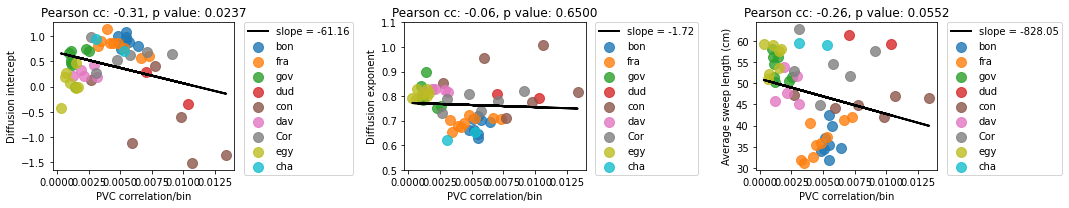

In [12]:
#plot width against replay_exponent for each animal, each with different color in subplot 1
#using all_width_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_peak_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
all_corrbin_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_peak_sweep_len_perday_ave[key] = np.mean(all_peak_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    all_corrbin_perday_ave[key] = np.mean(all_corrbin_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_peak_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
all_corrbin_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_peak_sweep_len_perday_concat.setdefault(key[0], []).append(all_peak_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
    all_corrbin_perday_concat.setdefault(key[0], []).append(all_corrbin_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(15,3))

plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, intercept_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion intercept')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#intercept
plt.subplot(1,3,2)

#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(1,3,3)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_corrbin_perday_concat[name]), 
                np.array(all_peak_sweep_len_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_peak_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
plt.plot(corrbin_np, corrbin_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('PVC correlation/bin')
plt.ylabel('Average sweep length (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


In [14]:
#save the results fpr paper plots using pickle
#results to be saved are as follows:
# all_offsets
# all_mean_diagonal_sums
# all_corr_matrix
# all_unique_nan_index
# animal_names
# all_corrbin_perday_concat
# all_sweep_len_perday_concat
# all_exponent_perday_concat

import pickle
with open('./sweep_replay_correlation_with_PVC.pickle', 'wb') as f:
    pickle.dump([all_offsets, all_mean_diagonal_sums, all_corr_matrix, all_unique_nan_index, animal_names, all_corrbin_perday_concat, all_sweep_len_perday_concat, all_peak_sweep_len_perday_concat, all_exponent_perday_concat], f)